<h1>Narrative Arc Sherlock Holmes</h1>

by David Siegl

In [1]:
import pandas as pd
import nltk
import os
from collections import defaultdict
from collections import Counter
import re
import string
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /home/david/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/david/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/david/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/david/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/david/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

<h2>Preprocessing</h2>

The complete works of Sherlock Holmes were downloaded as individual text files through this website archive https://sherlock-holm.es/.

As a first step of the preprocessing pipeline we read every text file, extract its title, remove some unnecessary lines and finally build a dictionary with the keys corresponding to the respective title and the values to each text accordingly. The created dictionary is then converted into a dataframe.

In [2]:
df_dict = defaultdict(str)
title = None

for f in os.listdir('./data/sherlock/'):
    with open('./data/sherlock/' + f, 'r') as text:
        lines = text.readlines()
        text.seek(0)
        ls = list()
        for number, line in enumerate(lines):
            if number == 4: # extracting the title of each story as a key
                title = line
                title = title.strip()
            elif number not in [4, 6] and line != "\n": # skipping unneccesary lines
                ls.append(line.strip(" "))
            
        conc_text = "".join(ls)
        conc_text = re.sub(r'[-]{10}\n([\S\s]+)', '', conc_text) # removing additional lines at the bottom of the text files
        conc_text = conc_text.strip()
        df_dict[title] = conc_text

In [3]:
df_sherlock = pd.DataFrame.from_dict(df_dict, orient='index', columns=['text'])
df_sherlock.index.name = 'title'

For additional information and more data granularity we also add for each title the year of its first publication in 'The Strand'. Since this information was not provided in the original text files, the individual years were scraped manually from the web and are put together into an array in correct order.

In [4]:
years = [1926, 1924, 1904, 1904, 1892, 1904, 1926, 1892, 1891, 1908, 1892, 1904, 1892, 1923, 1893, 1903, 1910, 1913, 1903, 1892, 1893, 1891, 1893, 1904, 1893, 1901, 1891, 1924, 1911, 1917, 1926, 1921, 1904, 1893, 1893, 1892, 1903, 1904, 1911,1891, 1893, 1893, 1926, 1891, 1904, 1927, 1890, 1892, 1904, 1903, 1892, 1891,1887, 1924, 1922, 1891, 1915, 1927, 1892, 1893]

df_sherlock['year'] = years


Next we apply common preprocessing steps such as punctuation and stopwords removal. Note that the different steps of feature engineering which we apply further down below in some regards require different formats of input. For example the VADER package for sentiment analysis also takes punctuation into account and works on a sentence level while the measuring of narrative coherence looks specifically for the distribution of stopwords in a given text sequence. This aspect is then reflected in the fact that our preprocessing pipeline branches off into different subtasks, whereas some branches also include the removal of stopwords and punctuation while others do not and therefore stay closer to the raw text format. 

In [5]:
def remove_numeric(text):
    return re.sub(r'\d+', '', text)

df_sherlock['text_prepro'] = df_sherlock['text'].apply(lambda x: remove_numeric(x))

In addition we also have to segment each text into 5 parts of equal length in order to compute local values for certain points in narrative time which can then be compared according to the notion of a narrative arc. Here we opt for a value of 5 segments because it firstly corresponds to the traditional notion of the dramatic climactic progression of rise and fall and is secondly also supported by the relevant literature which has been consulted beforehand (cf. for example the classical Aristotelian model of dramatic progression).

In [6]:
def segment_text (text):
    segment_length = len(text) // 5
    segments = [text[i:i+segment_length] for i in range(0, len(text), segment_length)]
    return segments[:5]

<h3>Narrative Coherence</h3>

In [7]:
df_sherlock['text_prepro_narrative'] = df_sherlock['text_prepro'].str.lower()

In [8]:
translator = str.maketrans('', '', string.punctuation)

df_sherlock['text_prepro_narrative'] = df_sherlock['text_prepro_narrative'].apply(lambda x: x.translate(translator))

In [9]:
df_sherlock['text_prepro_narrative'] = df_sherlock['text_prepro_narrative'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [10]:
df_sherlock['segments_narrative'] = df_sherlock['text_prepro_narrative'].apply(segment_text)

df_sherlock_segments_narrative = df_sherlock.explode('segments_narrative')

In [11]:
values = list(range(1, 6)) * ((len(df_sherlock_segments_narrative) // 5) + 1)
df_sherlock_segments_narrative['segment_num'] = values[:len(df_sherlock_segments_narrative)]

<h3>Temporal Usage</h3>

In [12]:
df_sherlock['text_prepro_temp'] = df_sherlock['text_prepro'].str.lower()

In [13]:
df_sherlock['text_prepro_temp'] = df_sherlock['text_prepro_temp'].apply(lambda x: x.translate(translator))

In [14]:
stopwords = nltk.corpus.stopwords.words('english')

df_sherlock['text_prepro_temp'] = df_sherlock['text_prepro_temp'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [15]:
df_sherlock['text_prepro_temp'] = df_sherlock['text_prepro_temp'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [16]:
df_sherlock['segments_temp'] = df_sherlock['text_prepro_temp'].apply(segment_text)

df_sherlock_segments_temp = df_sherlock.explode('segments_temp')

In [17]:
values = list(range(1, 6)) * ((len(df_sherlock_segments_temp) // 5) + 1)
df_sherlock_segments_temp['segment_num'] = values[:len(df_sherlock_segments_temp)]

<h3>Emotion Analysis</h3>

In [18]:
df_sherlock['text_prepro_tok_vader'] = df_sherlock['text_prepro'].apply(lambda x: nltk.tokenize.sent_tokenize(x))

In [19]:
df_sherlock['segments_vader'] = df_sherlock['text_prepro_tok_vader'].apply(segment_text) 

df_sherlock_segments_vader = df_sherlock.explode('segments_vader')

In [20]:
values = list(range(1, 6)) * ((len(df_sherlock_segments_vader) // 5) + 1)
df_sherlock_segments_vader['segment_num'] = values[:len(df_sherlock_segments_vader)]

<h3>Named Entity Recognition</h3>

In [21]:
df_sherlock['text_prepro_ner'] = df_sherlock['text_prepro'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [22]:
df_sherlock['segments_ner'] = df_sherlock['text_prepro_ner'].apply(segment_text)

df_sherlock_segments_ner = df_sherlock.explode('segments_ner')

In [23]:
values = list(range(1, 6)) * ((len(df_sherlock_segments_ner) // 5) + 1)
df_sherlock_segments_ner['segment_num'] = values[:len(df_sherlock_segments_ner)]

In [24]:
df_sherlock_segments_temp.reset_index(inplace=True)
df_sherlock_segments_narrative.reset_index(inplace=True)
df_sherlock_segments_vader.reset_index(inplace=True)
df_sherlock_segments_ner.reset_index(inplace=True)

<h3>Lemmatisation</h3>

In [85]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lem_text(text):
    lemmed_words = [lemmatizer.lemmatize(word) for word in text]
    return ' '.join(lemmed_words)

df_sherlock['text_lemmed'] = df_sherlock['text_prepro_temp'].apply(lem_text)

<h2> EDA </h2>

In order to obtain a better understanding on the data we first do some basic EDA such as for example the extraction of the distribution of text length throughout the whole dataset which will help with normalisation further down the pipeline.

Text(0, 0.5, 'Count')

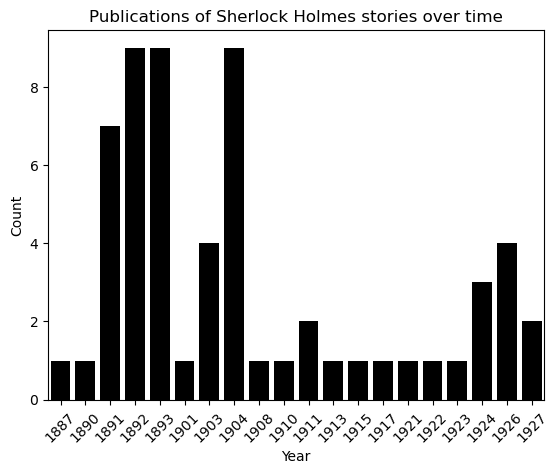

In [78]:
sns.countplot(df_sherlock, x='year', color='black')
plt.xticks(rotation=45)
plt.title('Publications of Sherlock Holmes stories over time')
plt.xlabel('Year')
plt.ylabel('Count')

The examination of the publication count of Sherlock Holmes stories per year displays a significant peak around the early 1890s, which can also corresponds to the rise in popularity of Doyle's hero. After 1893 the count of publications suddenly plummets and stays that way until the turn of the 20th century. This phenomenon can be explained by Doyle's (temporary) decision to kill off his protagonist. The continuation and subsequent rise of publications then corresponds to the literary resurrection of Holmes which reaches as far as into the late 1920s until the detective's last case and his retirement.

In [79]:
df_sherlock['word_counts'] = df_sherlock['text'].apply(lambda x: len(x.split()))

Text(0, 0.5, 'Count')

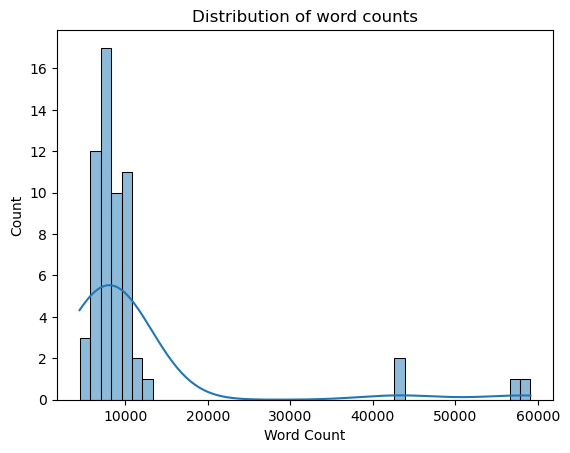

In [80]:
sns.histplot(df_sherlock, x='word_counts', kde=True)
plt.title('Distribution of word counts')
plt.xlabel('Word Count')
plt.ylabel('Count')

This basic histogram already displays a considerable skew of the data towards shorter texts of around 5000 words, which can be mainly explained by the fact that the original Sherlock Holmes stories were mainly published as a series of short stories within the literature magazine 'The Strand'.

In [81]:
df_sherlock.nlargest(5, 'word_counts')[['word_counts']]

,word_counts
title,
THE HOUND OF THE BASKERVILLES,59108
THE VALLEY OF FEAR,57551
A STUDY IN SCARLET,43379
THE SIGN OF THE FOUR,42998
THE NAVAL TREATY,12603


Unsurprisingly, the four famous short novels are also the texts with the highest word counts.

In [83]:
df_sherlock["avg_sent_len"] = df_sherlock["text"].map(lambda x: np.mean([len(w.split()) for w in nltk.tokenize.sent_tokenize(x)]))

Text(0, 0.5, 'Count')

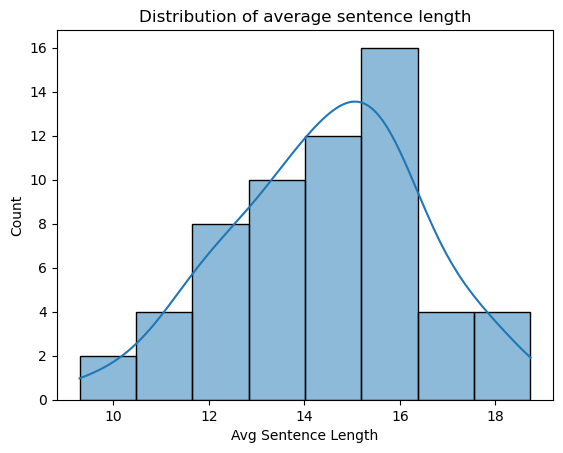

In [84]:
sns.histplot(df_sherlock, x='avg_sent_len', kde=True)
plt.title('Distribution of average sentence length')
plt.xlabel('Avg Sentence Length')
plt.ylabel('Count')

In [86]:
all_text = ' '.join(df_sherlock['text_lemmed'])
all_text = nltk.word_tokenize(all_text)
 
word_counts = Counter(all_text)
most_common = word_counts.most_common(25)

Text(0, 0.5, 'Words')

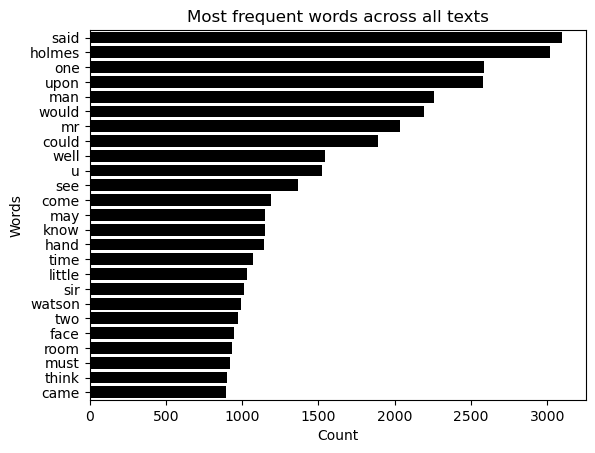

In [89]:
words, frequency = [], []
for word, count in most_common:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words, color='black')
plt.title('Most frequent words across all texts')
plt.xlabel('Count')
plt.ylabel('Words')

The extraction of the most common words across the stories of Sherlock Holmes do not provide too much of a surprise at a first glance: The frequent mentioning of the two protagonists names (Holmes and Watson) are to be expected. Furthermore the frequent usage of basic verbs might already suggest the establishing of a certain narrative tension throughout a given story. Last but not least the high occurence of spatial nouns such as 'room', 'door' or 'night' point towards a reliance on topological relations to drive the narrative forward, which will be further explored when will be looking at NER.

In [97]:
df_sherlock['text_prepro_ngrams'] = df_sherlock['text_prepro'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df_sherlock['text_prepro_ngrams'])
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

Text(0, 0.5, 'Count')

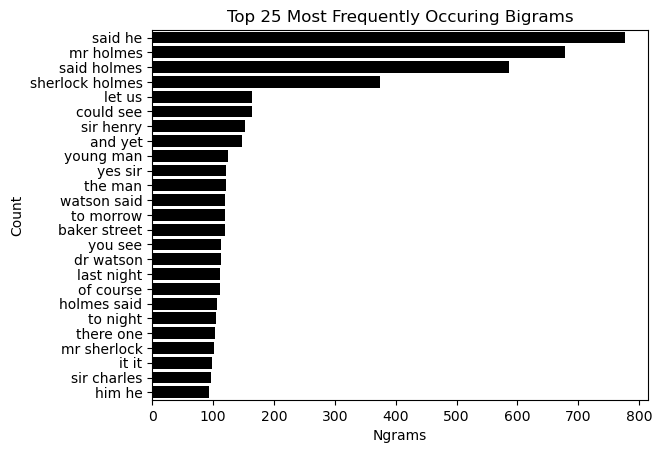

In [98]:
sns.barplot(x=ngram_freq['frequency'][:25], y=ngram_freq['ngram'][:25], color='black')
plt.title('Top 25 Most Frequently Occuring Bigrams')
plt.xlabel('Ngrams')
plt.ylabel('Count')

In [99]:
cv2 = CountVectorizer(ngram_range=(3,3))
trigrams = cv2.fit_transform(df_sherlock['text_prepro_ngrams'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv2.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

Text(0, 0.5, 'Count')

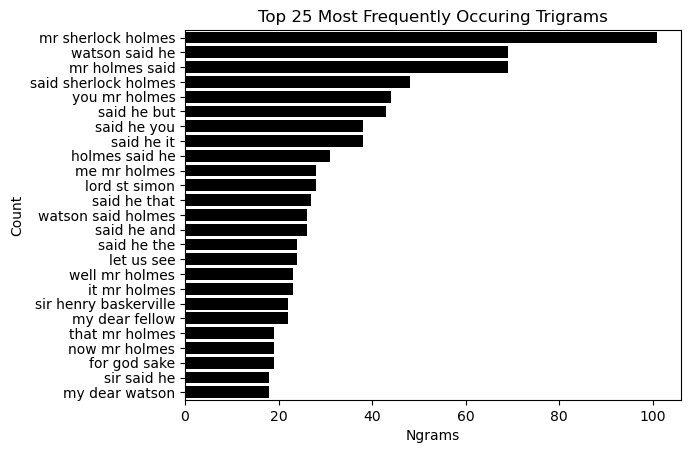

In [100]:
sns.barplot(x=ngram_freq['frequency'][:25], y=ngram_freq['ngram'][:25], color='black')
plt.title('Top 25 Most Frequently Occuring Trigrams')
plt.xlabel('Ngrams')
plt.ylabel('Count')

The exploration of bi- and trigrams shows in addition a high occurence of dialog and/or interactions between persons (especially between Holmes and Watson), which is represented by the combination of character names and inquit verbs such as 'said', to move the plot forward.

<h2>Feature Engineering</h2>

After we have wrangled the data to our needs and also did some basic NLP analysis on the texts, the next step (and probably also most crucial) will be about the computation of different, more complex features from the preprocessed data which correspond directly to the main goal of measuring the narrative arc or trajectory of the adventures of Sherlock Holmes. In most cases this will be accomplished by calculating certain frequencies of words, sequences and other entities which are of interest for our purposes for a given instance (except for the last task of Emotion Analysis). Given that our EDA has shown that the lengths of the texts in our dataset differ at least in some cases we have to take this fact into account as well when computing our frequencies. Fortunately this problem can easily be solved with the help of TF-IDF - a common normalisation approach in NLP which will be explained in more detail further down below.

<h3> Narrative Coherence </h3>

Our first task of feature engineering was inspired by Boyd et al. and their approach of defining and extracting three basic stages that constitute a given narrative text(for a more detailed discussion of their paper please refer to the underlying master's thesis). Boyd et al. use a dictionary containing different keywords whereas each keyword is matched to one of the three stages to denote its respective contribution to the establishing of a certain plot element within the overarching trajectory of narrative coherence. Said dictionary is freely available under https://osf.io/wpcx8 and will also be used for our purposes.

Thus, we create three lists from the dictionary, each of them containing certain keywords that we then match against the segment of the texts of Sherlock Holmes within our dataframe. Each match for each of the three narrative stages is then summed up per segment and in a separate column.

In [25]:
keywords_dict = pd.read_csv('./data/AON Dict - Without Overlaps.dic', sep='\t')

keywords_dict.reset_index(inplace=True)

keywords_dict = keywords_dict.iloc[4:]

keywords_dict['index'] = keywords_dict['index'].str.replace('*', '')

In [26]:
df_staging = keywords_dict.loc[keywords_dict['%'] == '1']
staging = df_staging['index'].tolist()

df_plot_progress = keywords_dict.loc[keywords_dict['%'] == '2']
plot_progress = df_plot_progress['index'].tolist()

df_cognitive_tension = keywords_dict.loc[keywords_dict['%'] == '3']
cognitive_tension = df_cognitive_tension['index'].tolist()

In [27]:
def count_matches(tokens, word_list):
    count = sum([1 for token in tokens if token in word_list])
    return count

df_sherlock_segments_narrative['staging_count'] = df_sherlock_segments_narrative.apply(lambda row: count_matches(row['segments_narrative'], staging), axis=1)

df_sherlock_segments_narrative['plot_progress_count'] = df_sherlock_segments_narrative.apply(lambda row: count_matches(row['segments_narrative'], plot_progress), axis=1)

df_sherlock_segments_narrative['cognitive_tension_count'] = df_sherlock_segments_narrative.apply(lambda row: count_matches(row['segments_narrative'], cognitive_tension), axis=1)

As previously mentioned, we have to take into account the differing lengths of our texts when computing the frequencies of specific terms if we want to compare them afterwards. For this purpose we define the following function which implements the TF-IDF formula on a given dataframe and then also normalises the results of TF-IDF to a value in the range of 0 and 1.

TF-IDF consists of three steps:
- The calculation of the term frequency (TF) which is defined by the frequency of a given term divided by the length of the text it occurs in.
- The calculation of the inverse document frequency (IDF) which is defined by the logarithm of the number of texts divided by the number of texts the given term occurs in.
- The multiplication of the two values which then results in the TF-IDF score.

In [28]:
def min_max_scale_column(df, new_column_name, col_to_norm, col_length):
    df['tf'] = df[col_to_norm] / len(df[col_length])
    df['idf'] = math.log(60) / (df[col_to_norm] != 0).value_counts()[True]
    df[new_column_name] = df['tf'] * df['idf']
    scaler = MinMaxScaler()
    df[new_column_name] = scaler.fit_transform(df[[new_column_name]])
    return df

In [29]:
df_sherlock_segments_narrative = min_max_scale_column(df_sherlock_segments_narrative, 'staging_count_norm', 'staging_count', 'text_prepro_narrative')

df_sherlock_segments_narrative = min_max_scale_column(df_sherlock_segments_narrative, 'plot_progress_count_norm', 'plot_progress_count', 'text_prepro_narrative')

df_sherlock_segments_narrative = min_max_scale_column(df_sherlock_segments_narrative, 'cognitive_tension_count_norm', 'cognitive_tension_count', 'text_prepro_narrative')

After we have computed our necessary values for the whole dataset, we can then run some basic statistical tests and also visualise their results. First we just calculate the mean and the standard deviation for each segment and plot them via barcharts and boxplots. Secondly we also run ANOVA tests which basically looks for significant deviations between the mean values of two or more categorical groups through the calculation of f-scores and p-values.

In [153]:
summary_stats_narrative = df_sherlock_segments_narrative[['segment_num', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm']].groupby('segment_num').agg(['mean', 'std'])

Text(0, 0.5, 'Plot Staging Frequency')

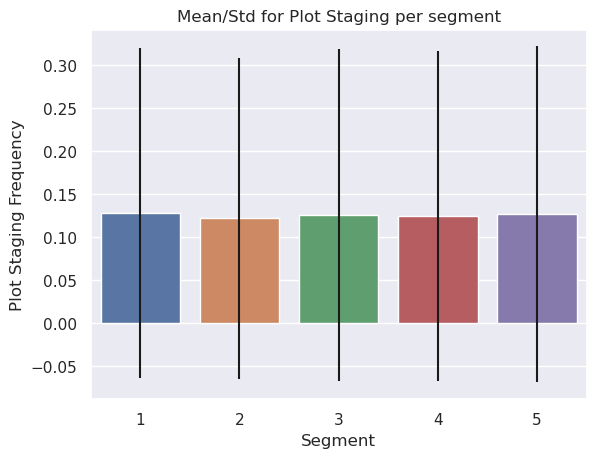

In [154]:
sns.set_theme()
sns.barplot(x=summary_stats_narrative.index, y=summary_stats_narrative[('staging_count_norm', 'mean')], yerr=summary_stats_narrative[('staging_count_norm', 'std')])
plt.title('Mean/Std for Plot Staging per segment')
plt.xlabel('Segment')
plt.ylabel('Plot Staging Frequency')

Text(0, 0.5, 'Plot Progression Frequency')

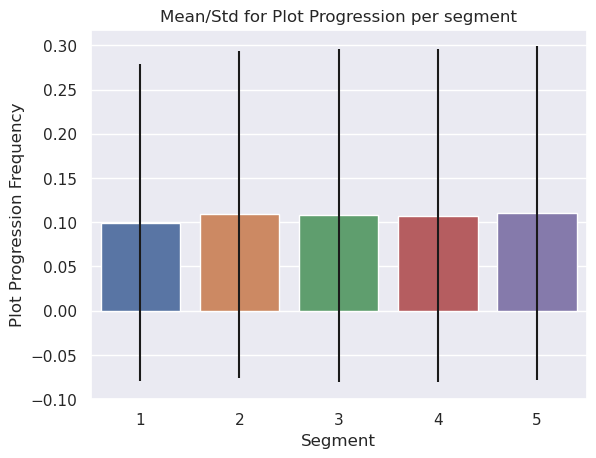

In [155]:
sns.set_theme()
sns.barplot(x=summary_stats_narrative.index, y=summary_stats_narrative[('plot_progress_count_norm', 'mean')], yerr=summary_stats_narrative[('plot_progress_count_norm', 'std')])
plt.title('Mean/Std for Plot Progression per segment')
plt.xlabel('Segment')
plt.ylabel('Plot Progression Frequency')

Text(0, 0.5, 'Plot Cognitive Tension Frequency')

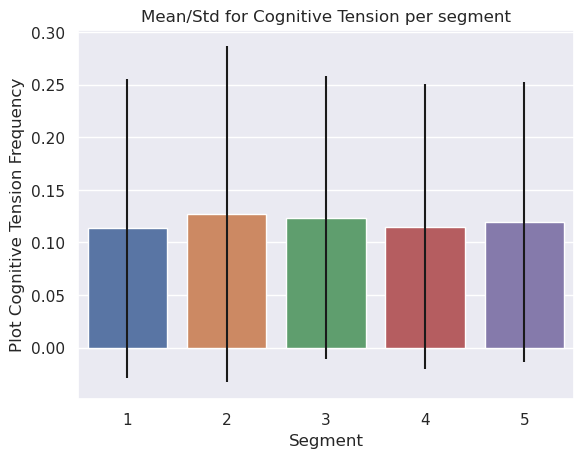

In [156]:
sns.set_theme()
sns.barplot(x=summary_stats_narrative.index, y=summary_stats_narrative[('cognitive_tension_count_norm', 'mean')], yerr=summary_stats_narrative[('cognitive_tension_count_norm', 'std')])
plt.title('Mean/Std for Cognitive Tension per segment')
plt.xlabel('Segment')
plt.ylabel('Plot Cognitive Tension Frequency')

In [158]:
summary_stats_narrative = summary_stats_narrative.reset_index()
summary_stats_narrative = pd.melt(summary_stats_narrative, id_vars=['segment_num'], var_name='category', value_name='value')
summary_stats_narrative = summary_stats_narrative.drop(index=summary_stats_narrative[(summary_stats_narrative['category'] == 'level_0') | summary_stats_narrative['category'] =='index'].index)

Text(0, 0.5, 'Narrative Cohesion Frequency')

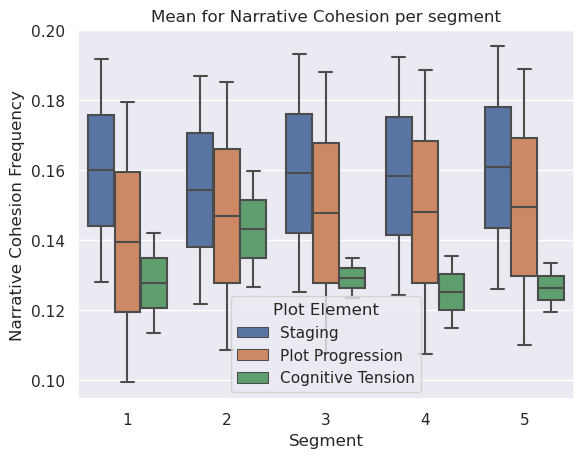

In [159]:
label_map = {'staging_count_norm' : 'Staging' , 'plot_progress_count_norm' : 'Plot Progression' , 'cognitive_tension_count_norm' : 'Cognitive Tension'}

summary_stats_narrative['Plot Element'] = summary_stats_narrative['category'].replace(label_map)

sns.set_theme()
sns.boxplot(data = summary_stats_narrative, x='segment_num', y='value', hue='Plot Element')
plt.title('Mean for Narrative Cohesion per segment')
plt.xlabel('Segment')
plt.ylabel('Narrative Cohesion Frequency')

In [85]:
def group_df(df, value):
    """this function takes as an input a df and groups it according to a given categorical variable for further ANOVA testing"""
    ls = []
    for i in range(1, df['segment_num'].nunique() + 1):
        ls.append(df[df['segment_num'] == i][value])
    return ls

In [86]:
ls_anova = group_df(df_sherlock_segments_narrative, 'staging_count_norm')

fvalue_staging, pvalue_staging = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for plot staging (fvalue, pvalue): {}, {}'.format(fvalue_staging, pvalue_staging))

Results for ANOVA test for plot staging (fvalue, pvalue): 0.009082105721400504, 0.9998359366838404


In [87]:
ls_anova = group_df(df_sherlock_segments_narrative, 'plot_progress_count_norm')

fvalue_progress, pvalue_progress = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for plot progression (fvalue, pvalue): {}, {}'.format(fvalue_progress, pvalue_progress))

Results for ANOVA test for plot progression (fvalue, pvalue): 0.030157002392953786, 0.9982417153229941


In [88]:
ls_anova = group_df(df_sherlock_segments_narrative, 'cognitive_tension_count_norm')

fvalue_cog, pvalue_cog = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for cognitive tension (fvalue, pvalue): {}, {}'.format(fvalue_cog, pvalue_cog))

Results for ANOVA test for cognitive tension (fvalue, pvalue): 0.09454006335117685, 0.9841444112445688


Text(0, 0.5, 'Value')

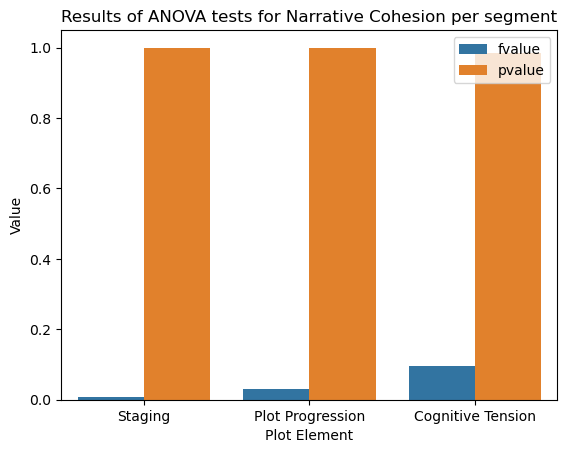

In [91]:
col1 = [fvalue_staging, fvalue_progress, fvalue_cog, pvalue_staging, pvalue_progress, pvalue_cog]
col2 = ['Staging', 'Plot Progression', 'Cognitive Tension', 'Staging', 'Plot Progression', 'Cognitive Tension']
col3 = ['fvalue', 'fvalue', 'fvalue', 'pvalue', 'pvalue', 'pvalue']

df_dict = {'value': col1, 'plot_element': col2, 'category_value': col3}

df_anova_narrative = pd.DataFrame(df_dict)

sns.set_theme()
g = sns.barplot(data = df_anova_narrative, x='plot_element', y ='value', hue = 'category_value')
g.get_legend().set_title("")
plt.title('Results of ANOVA tests for Narrative Cohesion per segment')
plt.xlabel('Plot Element')
plt.ylabel('Value')

Overall the plots as well as the ANOVA tests display no significant change of narrative cohesion between the different segments. In fact, especially the ANOVA metrics show that there is a very high chance that the perceived stability of narrative cohesion throughout the plots of Sherlock Holmes' stories are not due to random chance but very likely to also occur in similar populations.

Therefore we can conclude so far that the narrative coherence within the text corpus is mostly defined by a pattern of relative stability throughout narrative progression. To explore this trace further and follow this notion we now want to compare the different texts (not the sequences!) with one another based on the features we have just created beforehand. In order to achieve this task we again have to do same wrangling of the data: For this we basically represent each individual text via a vector consisting of the different values for all of its five sequences - i. e. every vector contains 5*3 values. We then go on to compute the cosine similarity of these vectors and finally also run a hierachical clustering algorithm on it to look whether or not there exists plausible evidence for the postulation of one or more archetypical narrative arcs.

In [93]:
df_sherlock_segments_narrative_vec = df_sherlock_segments_narrative[['title', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm']]

df_sherlock_segments_narrative_vec = df_sherlock_segments_narrative_vec.groupby('title').agg(lambda x: x.tolist())

df_sherlock_segments_narrative_vec['vector'] = df_sherlock_segments_narrative_vec.apply(lambda row: [val for sublist in row.values for val in sublist], axis=1)
df_sherlock_segments_narrative_vec.reset_index(inplace=True)
df_sherlock_segments_narrative_vec = df_sherlock_segments_narrative_vec[['title', 'vector']]

In [94]:
matrix_vec = np.array(df_sherlock_segments_narrative_vec['vector'].tolist())

similarity_matrix = cosine_similarity(matrix_vec)

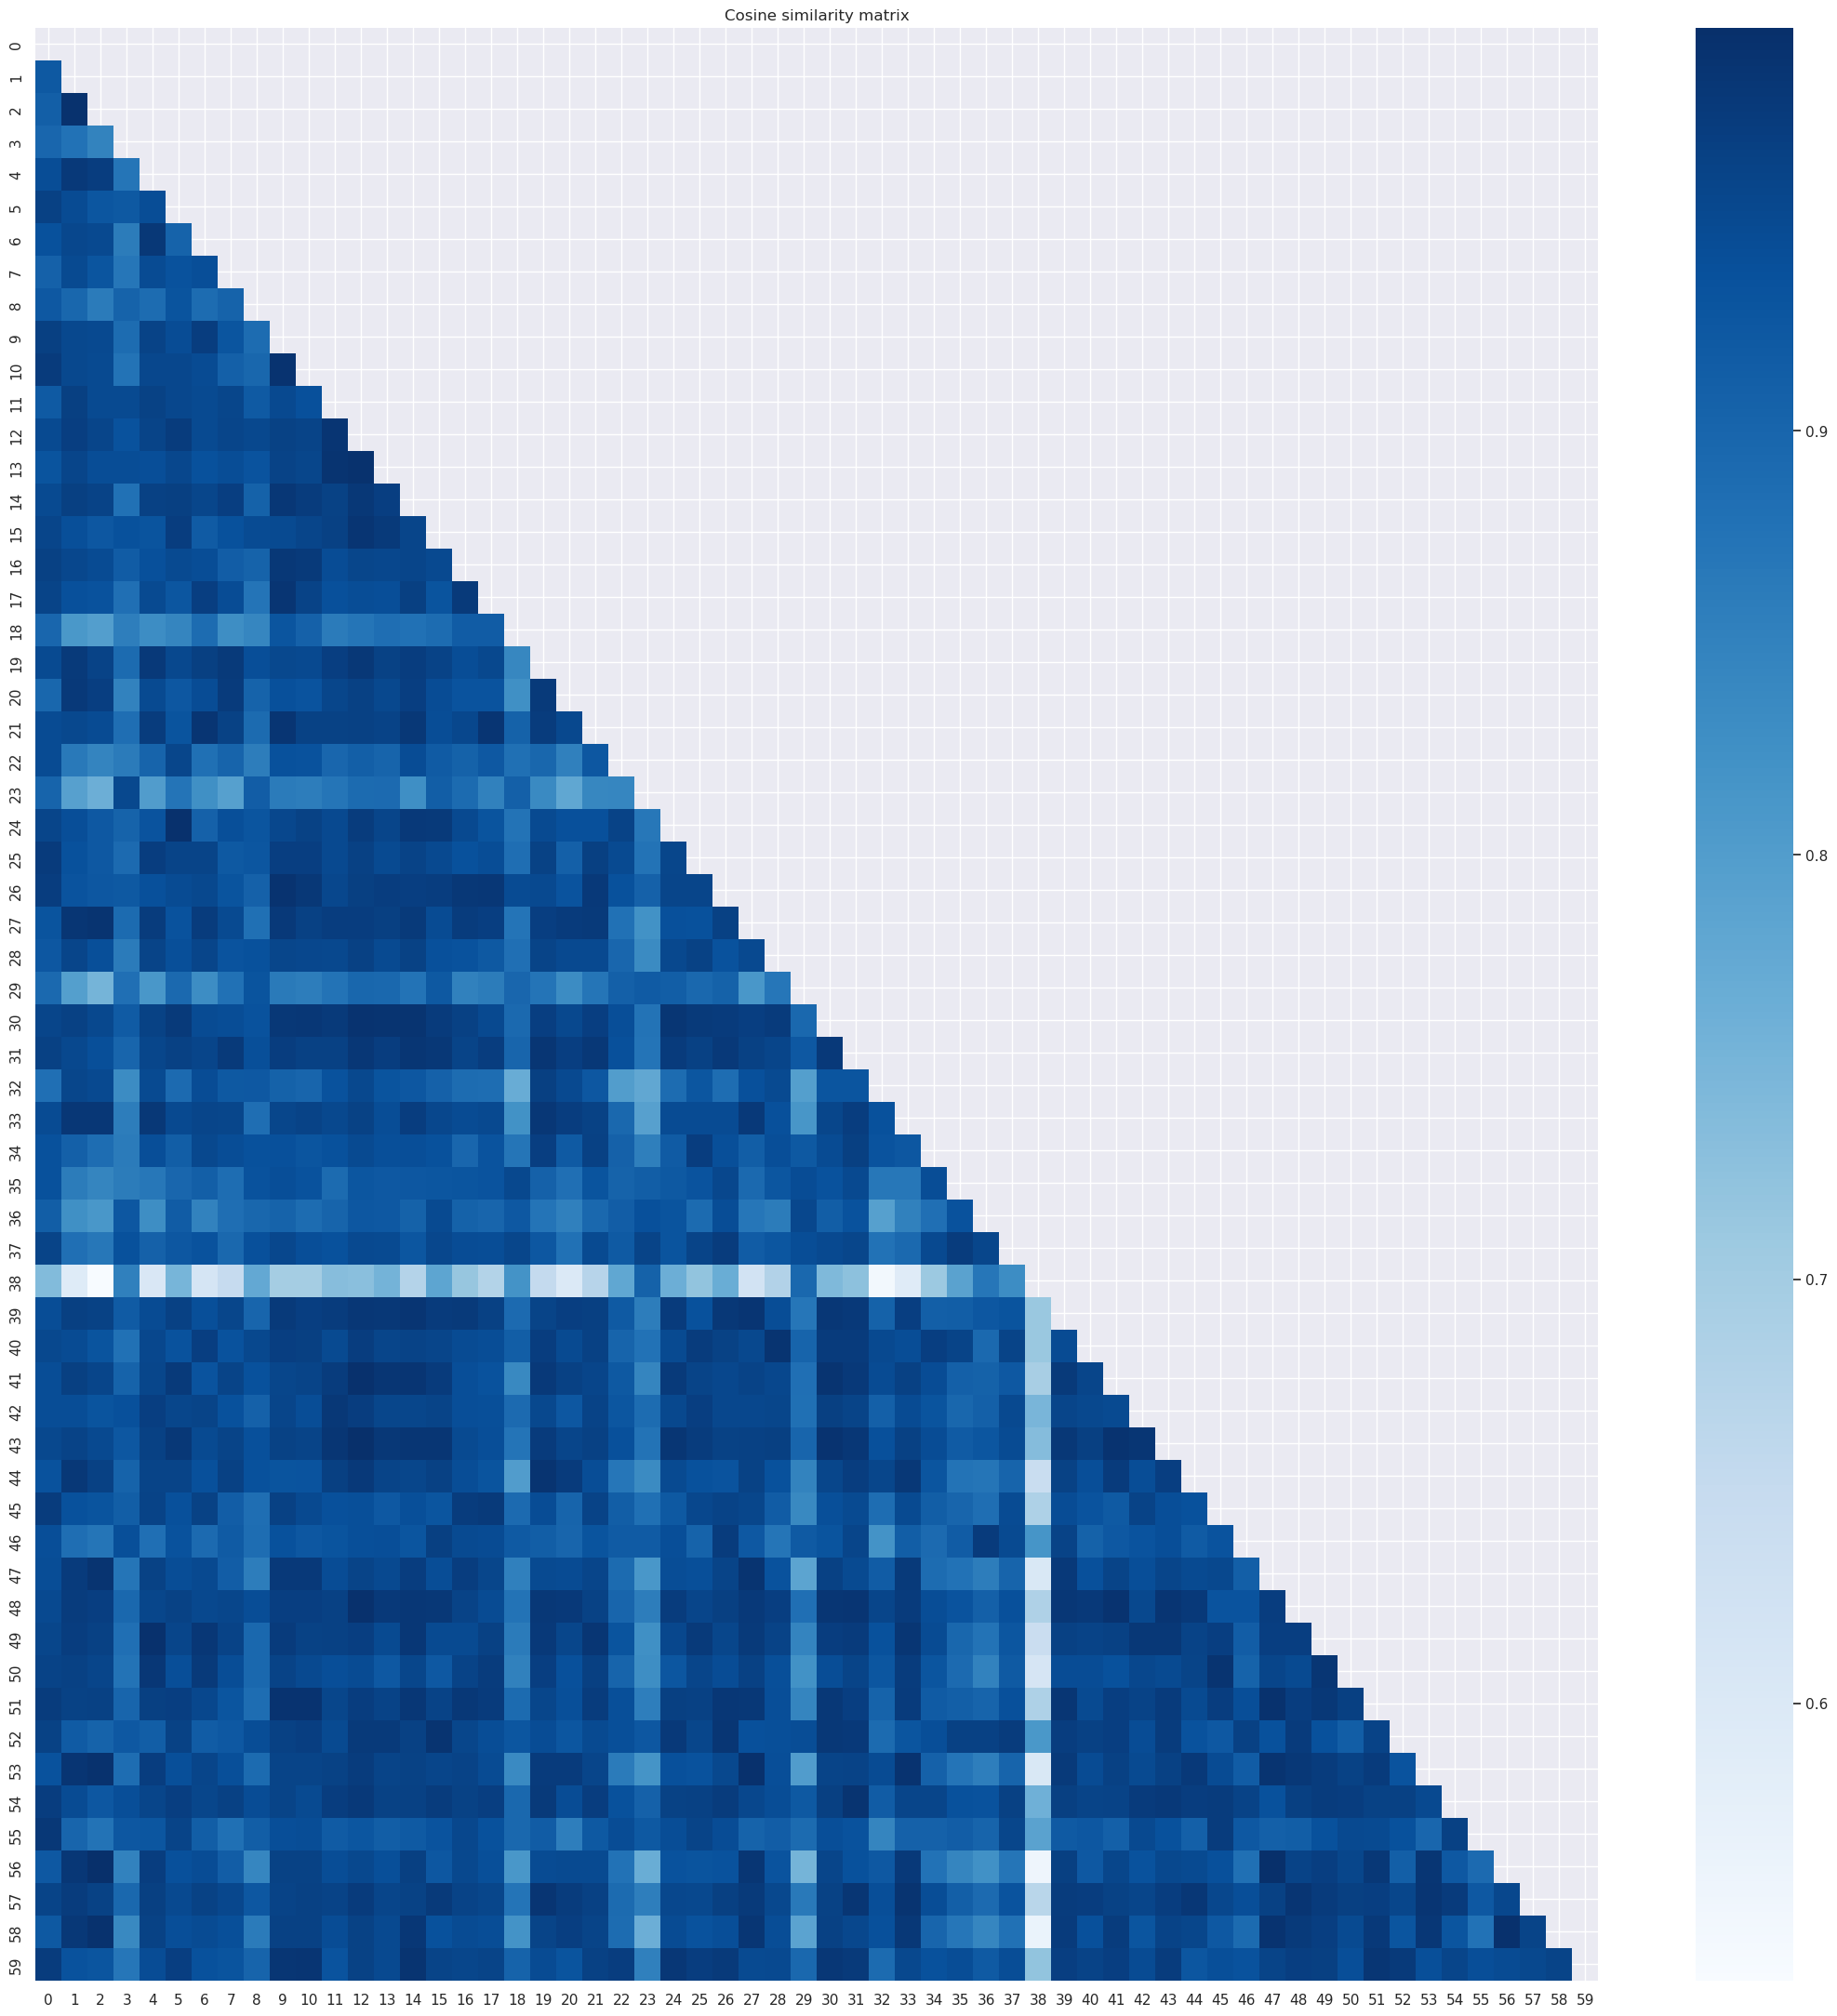

In [95]:
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarity_matrix, annot=False, cmap='Blues', mask=mask, ax=ax)
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.95, top=0.95)
plt.title('Cosine similarity matrix')

The visualisation of the results of the cosine similarity already suggests a high intrasimilarity across all the texts in our corpus. There are only a few instances (indicated by the lighter shades of blue) which do not conform the overall pattern.

We now turn to the hierarchical clustering to see whether this general trend can be confirmed in more detail.

Text(0, 0.5, 'Distance')

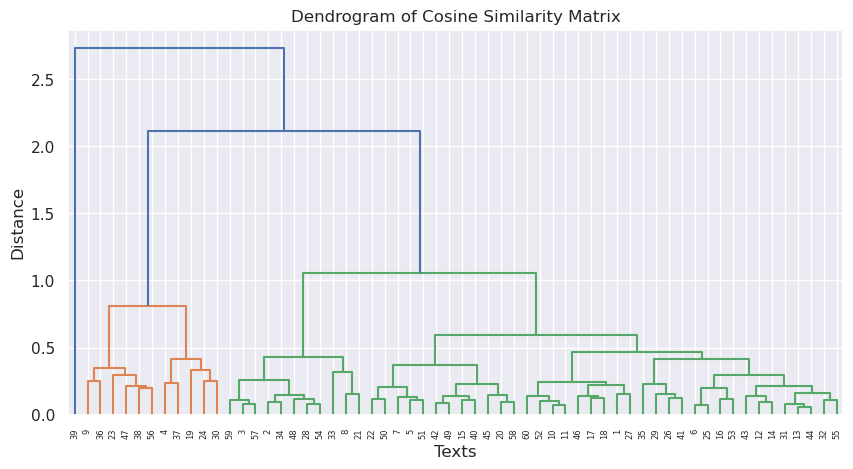

In [98]:
linkage_matrix = linkage(similarity_matrix, method='ward')

fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(linkage_matrix, labels=range(1,61))
plt.title('Dendrogram of Cosine Similarity Matrix')
plt.xlabel('Texts')
plt.ylabel('Distance')

The resulting dendrogram from applying hierarchical clustering to our data emphasises the observation of a general narrative consistency throughout the different texts even more. While most of the texts are put into one cluster (indicated by the green color), a considerable smaller group of texts is put into a second cluster (orange), while the distance between these two clusters nevertheless remains fairly small, therefore still suggesting a certain overarching similarity. Finally, only one text is put as an outlier into its own cluster which can be mainly explained due to random noise.

In [100]:
cluster_assignments = fcluster(linkage_matrix, t=3, criterion = 'maxclust')

df_sherlock_segments_narrative_vec['cluster'] = cluster_assignments

In [101]:
df_sherlock_segments_narrative = pd.merge(df_sherlock_segments_narrative, df_sherlock_segments_narrative_vec[['title', 'cluster']], on='title', how='left') # adding the retrieved cluster assignment to the initial dataframe

In [127]:
df_sherlock_pivot = df_sherlock_segments_narrative[['title', 'segment_num', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'cluster']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title', 'cluster'], var_name='var', value_name= 'val')

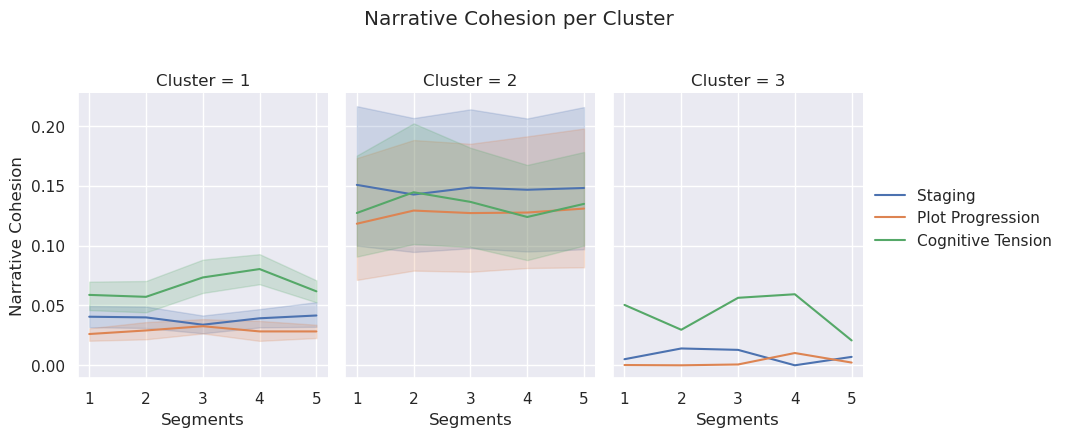

In [129]:
df_sherlock_pivot = df_sherlock_pivot.rename(columns={'cluster' : 'Cluster'})

label_map = {'staging_count_norm' : 'Staging' , 'plot_progress_count_norm' : 'Plot Progression' , 'cognitive_tension_count_norm' : 'Cognitive Tension'}

df_sherlock_pivot['Plot Element'] = df_sherlock_pivot['var'].replace(label_map)

fg = sns.FacetGrid(df_sherlock_pivot, col='Cluster')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='Plot Element')
fg.add_legend()
fg.fig.subplots_adjust(top=0.7, bottom=-0.25)
fg.set(xticks = range(1, 6, 1))
fg.fig.suptitle('Narrative Cohesion per Cluster')
fg.set_axis_labels('Segments' , 'Narrative Cohesion')

The visualisation of the narrative arc of the different clusters again confirms the already formulated notion that not only do the different clusters display a general stability in their respective narrative trajectory for the three different features of narrative coherence - they also show a general overarching similarity, pointing towards a genre-specific (or at least Sherlock Holmes specific) trend beyond the boundaries of individual texts.

In [104]:
df_sherlock_pivot_cluster1 = df_sherlock_pivot.loc[df_sherlock_pivot['Cluster'] == 1]

df_sherlock_pivot_cluster2 = df_sherlock_pivot.loc[df_sherlock_pivot['Cluster'] == 2]

df_sherlock_pivot_cluster3 = df_sherlock_pivot.loc[df_sherlock_pivot['Cluster']== 3]

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster1, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='Plot Element')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster2, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='Plot Element')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster3, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='Plot Element')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

<h3> Temporal Usage </h3>

Another important feature for measuring narrative progression can be found in the usage of temporal expressions and/or relations. For example the traditional structuralistic narratological research of detective fiction suggests that there often exists a certain achronological or analeptical structuring within the narration of crime stories such as the adventures of Sherlock Holmes where the exposition mainly revolves around the telling of the crime itself while the subsequent segments are then commited to the retelling or rather reconstruction of what had already happened signified by the investigations of the protagonist.

This obervation renders it all the more plausible to apply some POS tagging and then compute the frequencies of past, present and future tense usage across the different segments of a given text. To accomplish this task we define a function which then returns the counts of past, present and future tense verbs based on their respective tags as three distinct columns.

In [130]:
def pos_tag_text(text):
    pos_tags = nltk.pos_tag(text)
    return pos_tags

df_sherlock_segments_temp['text_pos'] = df_sherlock_segments_temp['segments_temp'].apply(pos_tag_text)

In [131]:
def tense_counts(pos_tags):
    """this function takes as an input an array of pos tags and computes the counts for past, present and future tense usage by grouping them into three distinct categories according to their respective tag"""
    past_count = 0
    present_count = 0
    future_count = 0
    
    for word, tag in pos_tags[1::2]:
        if tag.startswith('VBD'):
            past_count += 1
        elif tag.startswith('VB'):
            present_count += 1
        elif tag.startswith('MD'):
            future_count += 1
    
    counts = {'past_count': past_count,
              'present_count': present_count,
              'future_count': future_count}
    
    return pd.Series(counts)        
    
    
df_sherlock_segments_temp[['past_count', 'present_count', 'future_count']] = df_sherlock_segments_temp['text_pos'].apply(tense_counts)

After we have computed our frequencies, we again apply the normalisation function already discussed above.

In [133]:
df_sherlock_segments_temp = min_max_scale_column(df_sherlock_segments_temp, 'future_count_norm', 'future_count', 'text_prepro_temp')

df_sherlock_segments_temp = min_max_scale_column(df_sherlock_segments_temp, 'past_count_norm', 'past_count', 'text_prepro_temp')

df_sherlock_segments_temp = min_max_scale_column(df_sherlock_segments_temp, 'present_count_norm', 'present_count', 'text_prepro_temp')

In [134]:
df_sherlock_pivot = df_sherlock_segments_temp[['title', 'segment_num', 'future_count_norm', 'past_count_norm', 'present_count_norm']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title'], var_name='var', value_name= 'val')

In [146]:
summary_stats_tenses = df_sherlock_segments_temp[['segment_num', 'present_count_norm', 'future_count_norm', 'past_count_norm']].groupby('segment_num').agg(['mean', 'std'])

Text(0, 0.5, 'Present Tense Frequency')

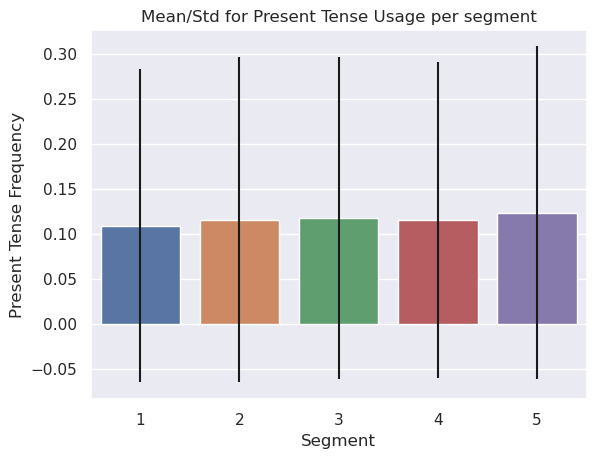

In [151]:
sns.set_theme()
sns.barplot(x=summary_stats_tenses.index, y=summary_stats_tenses[('present_count_norm', 'mean')], yerr=summary_stats_tenses[('present_count_norm', 'std')])
plt.title('Mean/Std for Present Tense Usage per segment')
plt.xlabel('Segment')
plt.ylabel('Present Tense Frequency')

Text(0, 0.5, 'Past Tense Frequency')

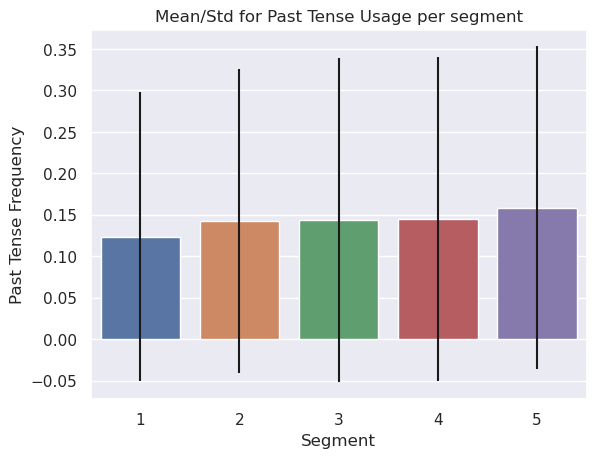

In [148]:
sns.set_theme()
sns.barplot(x=summary_stats_tenses.index, y=summary_stats_tenses[('past_count_norm', 'mean')], yerr=summary_stats_tenses[('past_count_norm', 'std')])
plt.title('Mean/Std for Past Tense Usage per segment')
plt.xlabel('Segment')
plt.ylabel('Past Tense Frequency')

Text(0, 0.5, 'Future Tense Frequency')

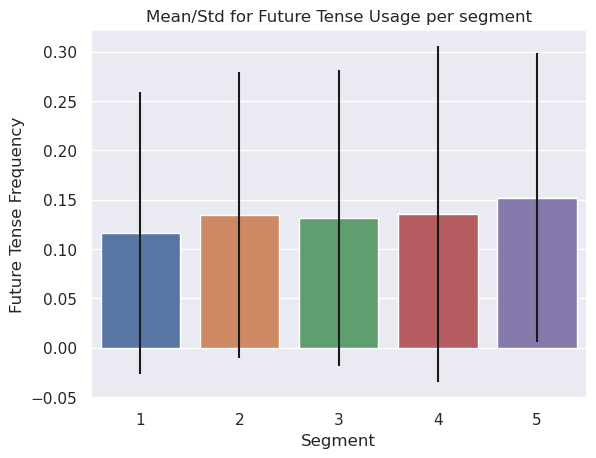

In [149]:
sns.set_theme()
sns.barplot(x=summary_stats_tenses.index, y=summary_stats_tenses[('future_count_norm', 'mean')], yerr=summary_stats_tenses[('future_count_norm', 'std')])
plt.title('Mean/Std for Future Tense Usage per segment')
plt.xlabel('Segment')
plt.ylabel('Future Tense Frequency')

In [161]:
summary_stats_tenses = summary_stats_tenses.reset_index()
summary_stats_tenses = pd.melt(summary_stats_tenses, id_vars=['segment_num'], var_name='stat', value_name='value')
summary_stats_tenses = summary_stats_tenses.drop(index=summary_stats_tenses[(summary_stats_tenses['stat'] == 'level_0') | summary_stats_tenses['stat'] =='index'].index)

Text(0, 0.5, 'Tense Usage Frequency')

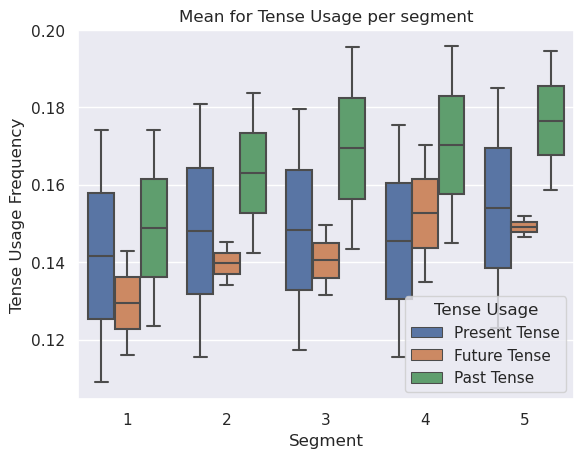

In [164]:
label_map = {'past_count_norm' : 'Past Tense' , 'present_count_norm' : 'Present Tense' , 'future_count_norm' : 'Future Tense'}

summary_stats_tenses['Tense Usage'] = summary_stats_tenses['stat'].replace(label_map)

sns.set_theme()
sns.boxplot(data = summary_stats_tenses, x='segment_num', y='value', hue='Tense Usage')
plt.title('Mean for Tense Usage per segment')
plt.xlabel('Segment')
plt.ylabel('Tense Usage Frequency')

In [140]:
ls_anova = group_df(df_sherlock_segments_temp, 'past_count_norm')

fvalue_past, pvalue_past = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for past tense usage (fvalue, pvalue): {}, {}'.format(fvalue_past, pvalue_past))

Results for ANOVA test for past tense usage (fvalue, pvalue): 0.2624311499079588, 0.9019034746678652


In [141]:
ls_anova = group_df(df_sherlock_segments_temp, 'present_count_norm')

fvalue_present, pvalue_present = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for present tense usage (fvalue, pvalue): {}, {}'.format(fvalue_present, pvalue_present))

Results for ANOVA test for present tense usage (fvalue, pvalue): 0.047365059057391835, 0.9957616207509549


In [142]:
ls_anova = group_df(df_sherlock_segments_temp, 'future_count_norm')

fvalue_future, pvalue_future = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for future tense usage (fvalue, pvalue): {}, {}'.format(fvalue_future, pvalue_future))

Results for ANOVA test for future tense usage (fvalue, pvalue): 0.42324687854693605, 0.7918329886020543


Text(0, 0.5, 'Value')

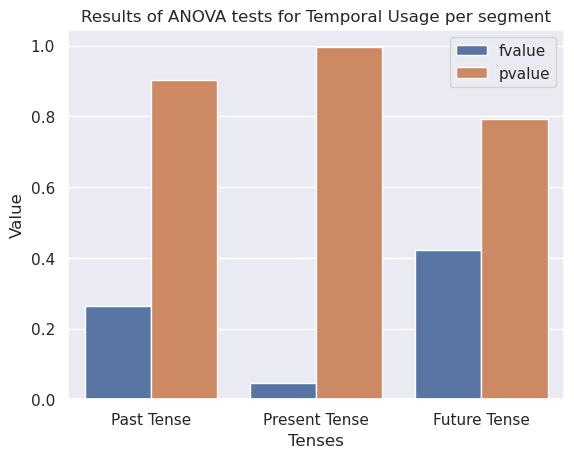

In [166]:
col1 = [fvalue_past, fvalue_present, fvalue_future, pvalue_past, pvalue_present, pvalue_future]
col2 = ['Past Tense', 'Present Tense', 'Future Tense', 'Past Tense', 'Present Tense', 'Future Tense']
col3 = ['fvalue', 'fvalue', 'fvalue', 'pvalue', 'pvalue', 'pvalue']

df_dict = {'value': col1, 'tense': col2, 'category_value': col3}

df_anova_tenses = pd.DataFrame(df_dict)

sns.set_theme()
g = sns.barplot(data = df_anova_tenses, x='tense', y ='value', hue = 'category_value')
g.get_legend().set_title("")
plt.title('Results of ANOVA tests for Temporal Usage per segment')
plt.xlabel('Tenses')
plt.ylabel('Value')

Again the statistical tests reveal similar patterns for the Temporal Usage across the different segments. The results suggest no significant difference throughout the narrative progression.

In [144]:
df_sherlock_segments_temp_vec = df_sherlock_segments_temp[['title', 'present_count_norm', 'past_count_norm', 'future_count_norm']]

df_sherlock_segments_temp_vec = df_sherlock_segments_temp_vec.groupby('title').agg(lambda x: x.tolist())

df_sherlock_segments_temp_vec['vector'] = df_sherlock_segments_temp_vec.apply(lambda row: [val for sublist in row.values for val in sublist], axis=1)
df_sherlock_segments_temp_vec.reset_index(inplace=True)
df_sherlock_segments_temp_vec = df_sherlock_segments_temp_vec[['title', 'vector']]  
matrix_vec = np.array(df_sherlock_segments_temp_vec['vector'].tolist())

similarity_matrix = cosine_similarity(matrix_vec)


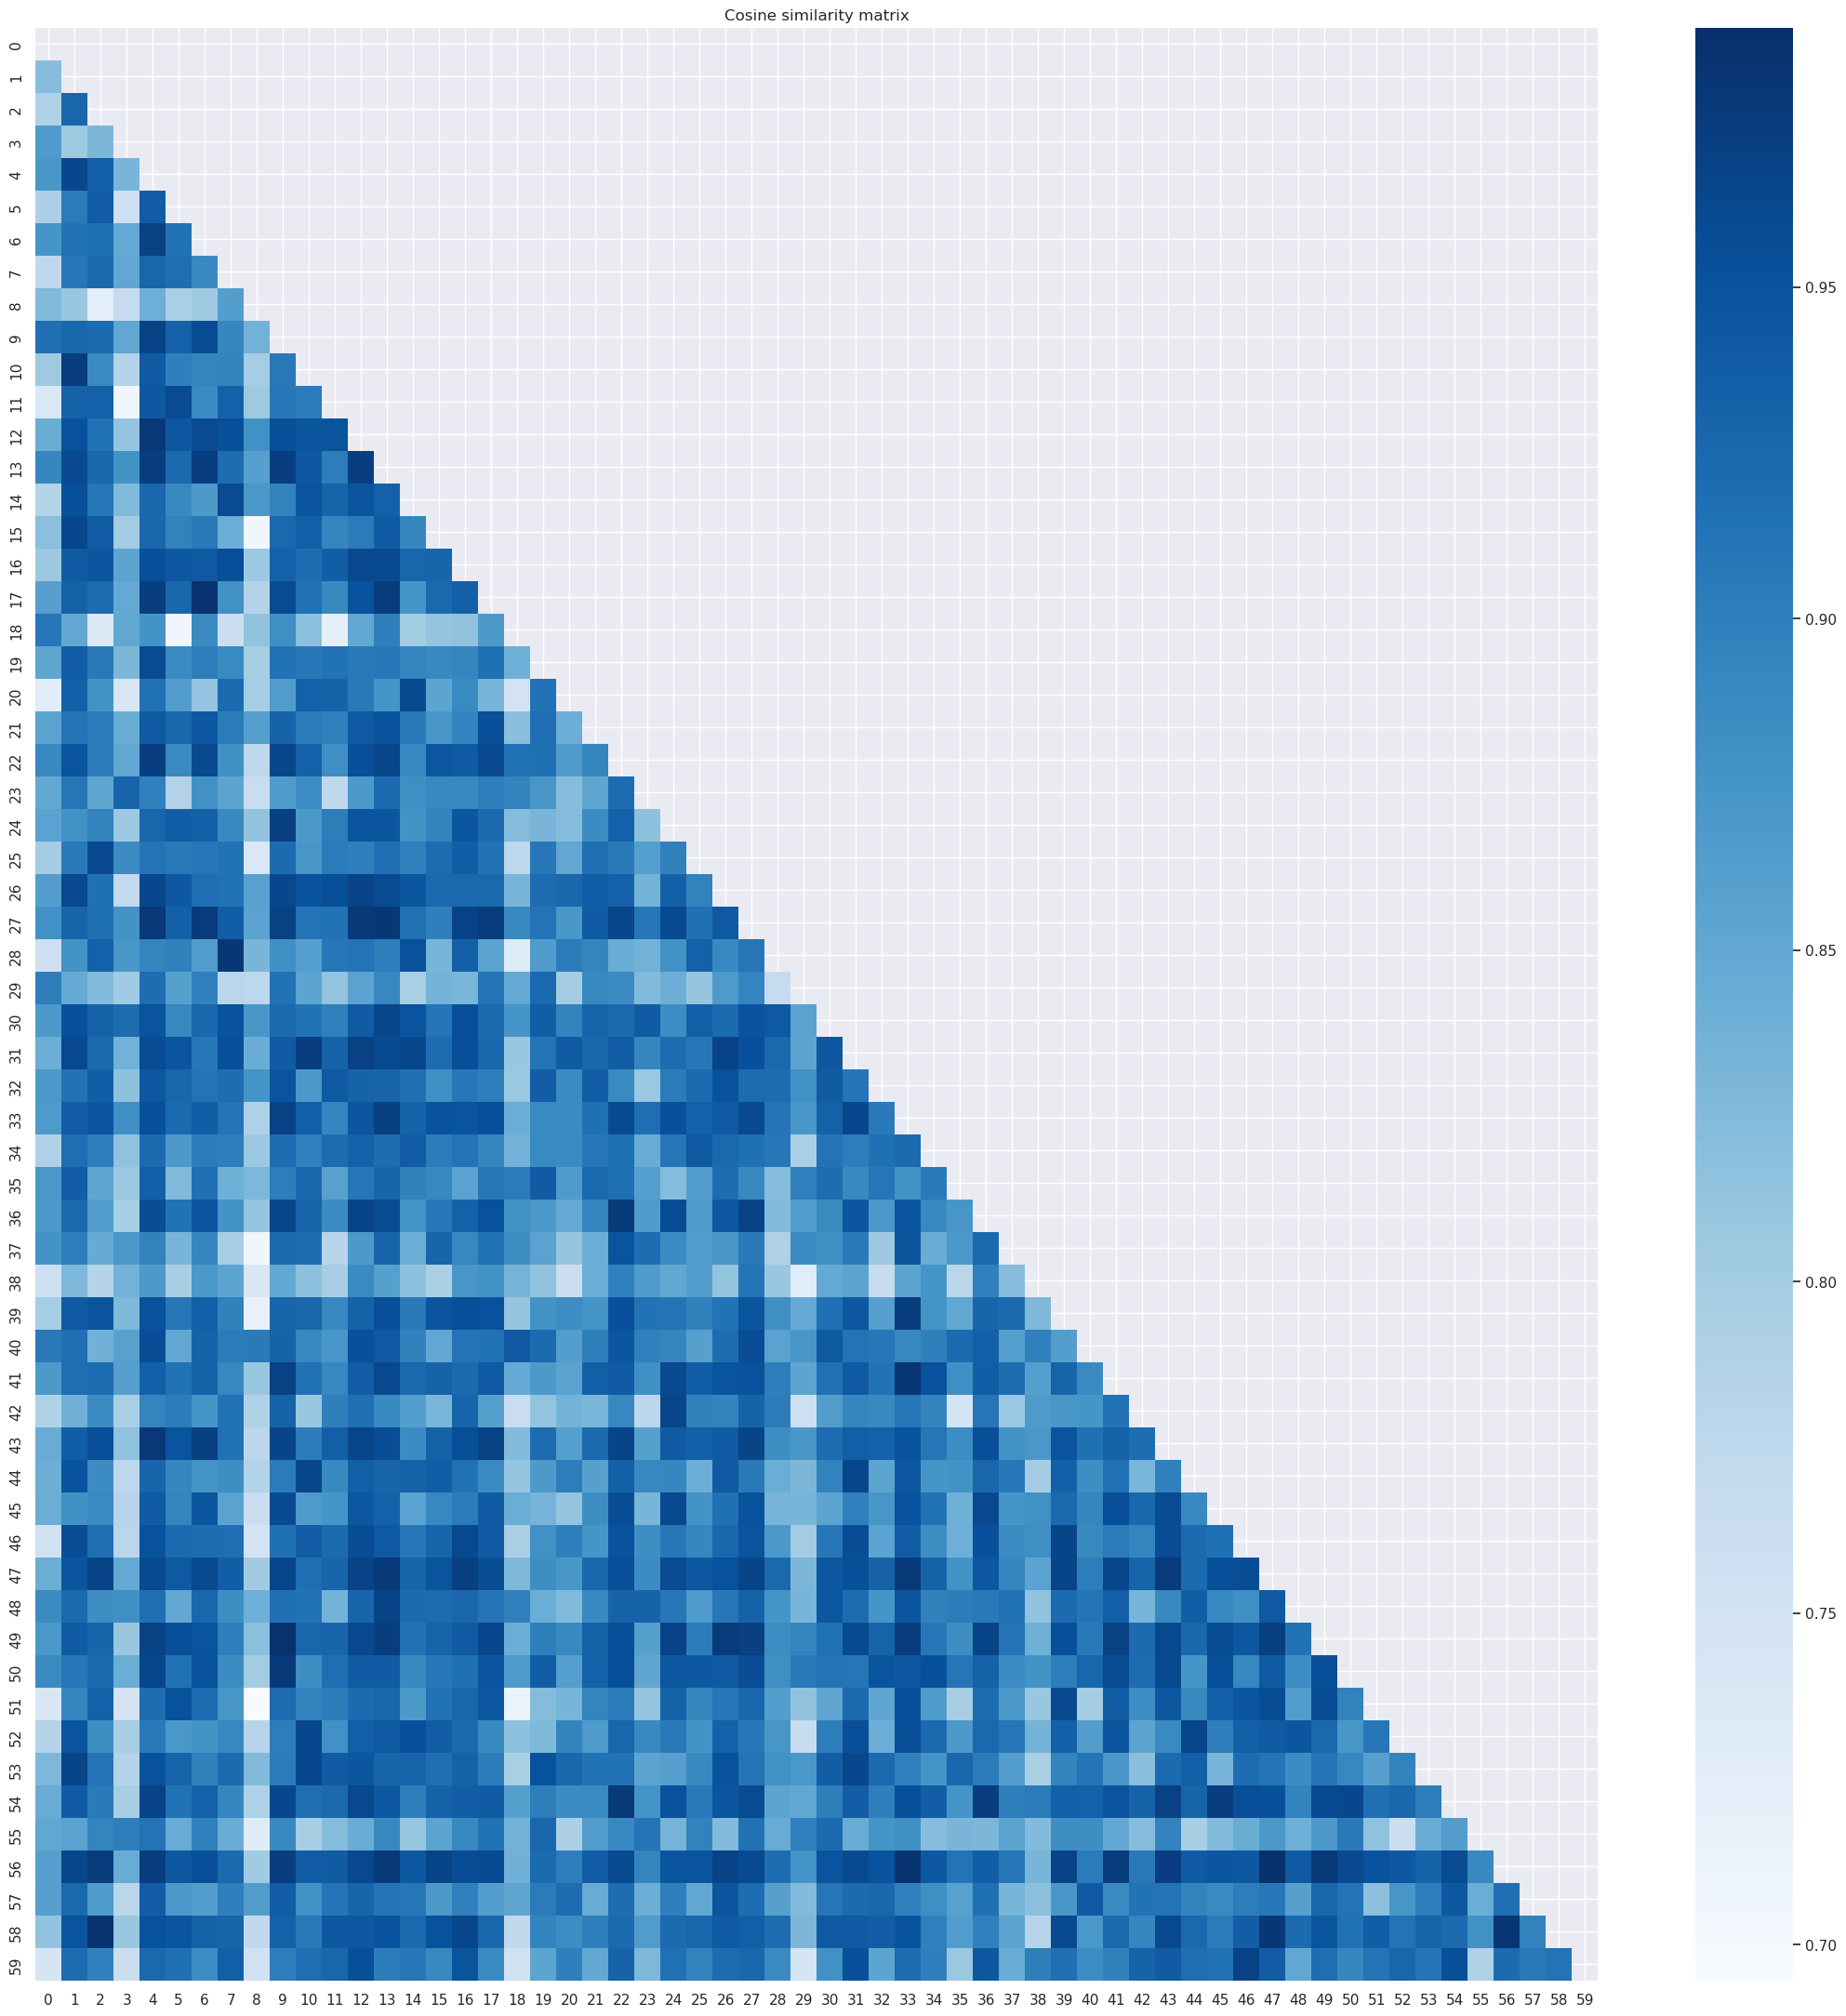

In [61]:
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarity_matrix, annot=False, cmap='Blues', mask=mask, ax=ax)
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.95, top=0.95)
plt.title('Cosine similarity matrix')
plt.show()

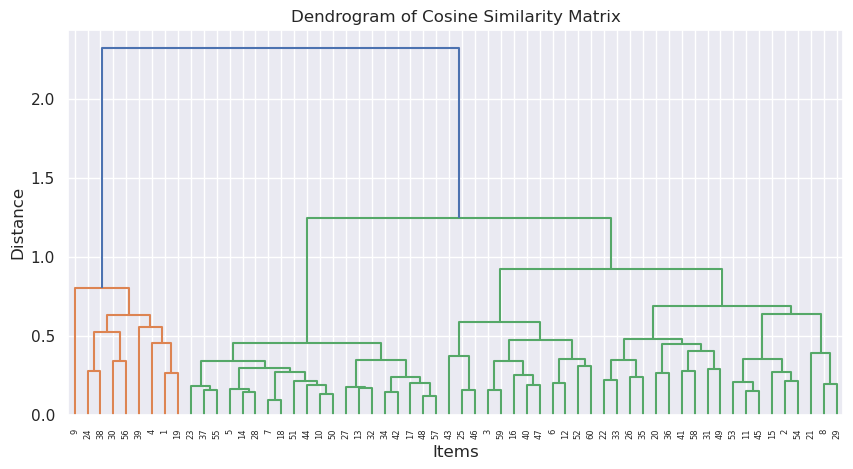

In [62]:
linkage_matrix = linkage(similarity_matrix, method='ward')

fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(linkage_matrix, labels=range(1,61))
plt.title('Dendrogram of Cosine Similarity Matrix')
plt.xlabel('Items')
plt.ylabel('Distance')
plt.show()

In [63]:
cluster_assignments = fcluster(linkage_matrix, t=2, criterion = 'maxclust')

df_sherlock_segments_temp_vec['cluster'] = cluster_assignments
df_sherlock_segments_temp = pd.merge(df_sherlock_segments_temp, df_sherlock_segments_temp_vec[['title', 'cluster']], on='title', how='left')
df_sherlock_pivot = df_sherlock_segments_temp[['title', 'segment_num', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'cluster']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title', 'cluster'], var_name='var', value_name= 'val')


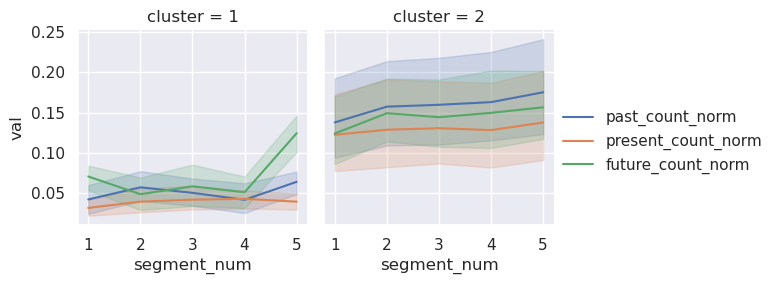

In [64]:
fg = sns.FacetGrid(df_sherlock_pivot, col='cluster')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.add_legend()

In [65]:
df_sherlock_pivot_cluster1 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster'] == 1]

df_sherlock_pivot_cluster2 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster'] == 2]

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster1, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster2, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

<h3> Emotion Analysis </h3>

In [69]:
vader = SentimentIntensityAnalyzer()

In [70]:
def get_sentiment_scores(sentence_list):
    scores = []
    for sentence in sentence_list:
        score = vader.polarity_scores(sentence)
        scores.append(score)
    return scores

df_sherlock_segments_vader['sentiment_score'] = df_sherlock_segments_vader['segments_vader'].apply(get_sentiment_scores)

get_avg_compound_score = lambda scores: sum([score['compound'] for score in scores])/len([score['compound'] for score in scores])
df_sherlock_segments_vader['avg_compound_score'] = df_sherlock_segments_vader['sentiment_score'].apply(get_avg_compound_score)

df_sherlock_segments_vader = df_sherlock_segments_vader.drop('sentiment_score', axis=1)

In [71]:
summary_stats_emotion = df_sherlock_segments_vader[['segment_num', 'avg_compound_score']].groupby('segment_num').agg(['mean', 'std'])

<Axes: xlabel='segment_num', ylabel="('avg_compound_score', 'mean')">

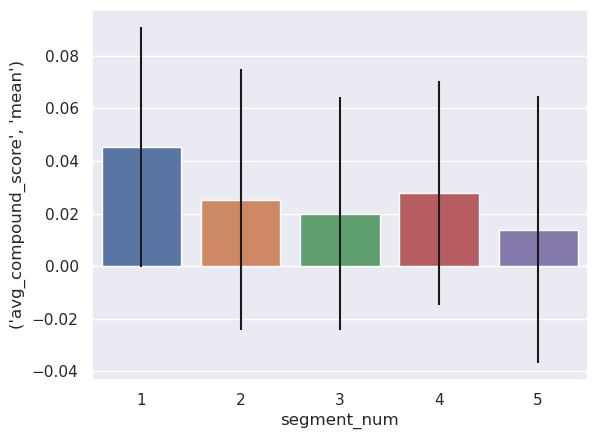

In [72]:
sns.barplot(x=summary_stats_emotion.index, y=summary_stats_emotion[('avg_compound_score', 'mean')], 
            yerr=summary_stats_emotion[('avg_compound_score', 'std')])

In [73]:
ls_anova = group_df(df_sherlock_segments_vader, 'avg_compound_score')

fvalue_emotion, pvalue_emotion = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for emotion analysis (fvalue, pvalue): {}, {}'.format(fvalue_emotion, pvalue_emotion))

Results for ANOVA test for emotion analysis (fvalue, pvalue): 3.8511919702664077, 0.00456500130063913


In [74]:
df_sherlock_pivot = df_sherlock_segments_vader[['title', 'segment_num', 'avg_compound_score']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title'], var_name='var', value_name= 'val')

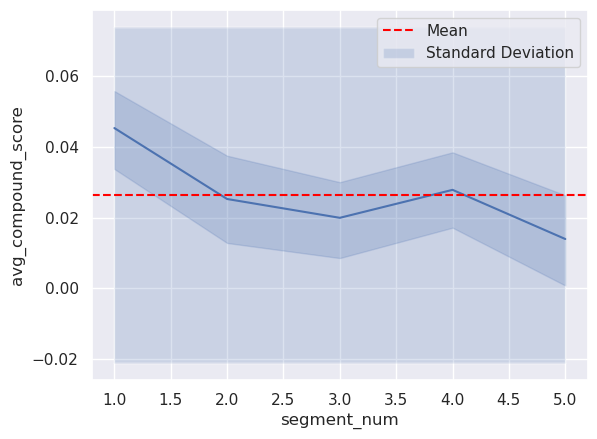

In [75]:
mean = df_sherlock_segments_vader['avg_compound_score'].mean()
std = df_sherlock_segments_vader['avg_compound_score'].std()

ax = sns.lineplot(x='segment_num', y='avg_compound_score', data=df_sherlock_segments_vader)
ax.axhline(mean, color='red', linestyle='--', label='Mean')
ax.fill_between(df_sherlock_segments_vader['segment_num'], mean-std, mean+std, alpha=0.2, label='Standard Deviation')
ax.legend()

In [76]:
df_sherlock_segments_vader_vec = df_sherlock_segments_vader[['title', 'avg_compound_score']]

df_sherlock_segments_vader_vec = df_sherlock_segments_vader_vec.groupby('title').agg(lambda x: x.tolist())

df_sherlock_segments_vader_vec.reset_index(inplace=True)

In [77]:
matrix_vec = np.array(df_sherlock_segments_vader_vec['avg_compound_score'].tolist())

similarity_matrix = cosine_similarity(matrix_vec)

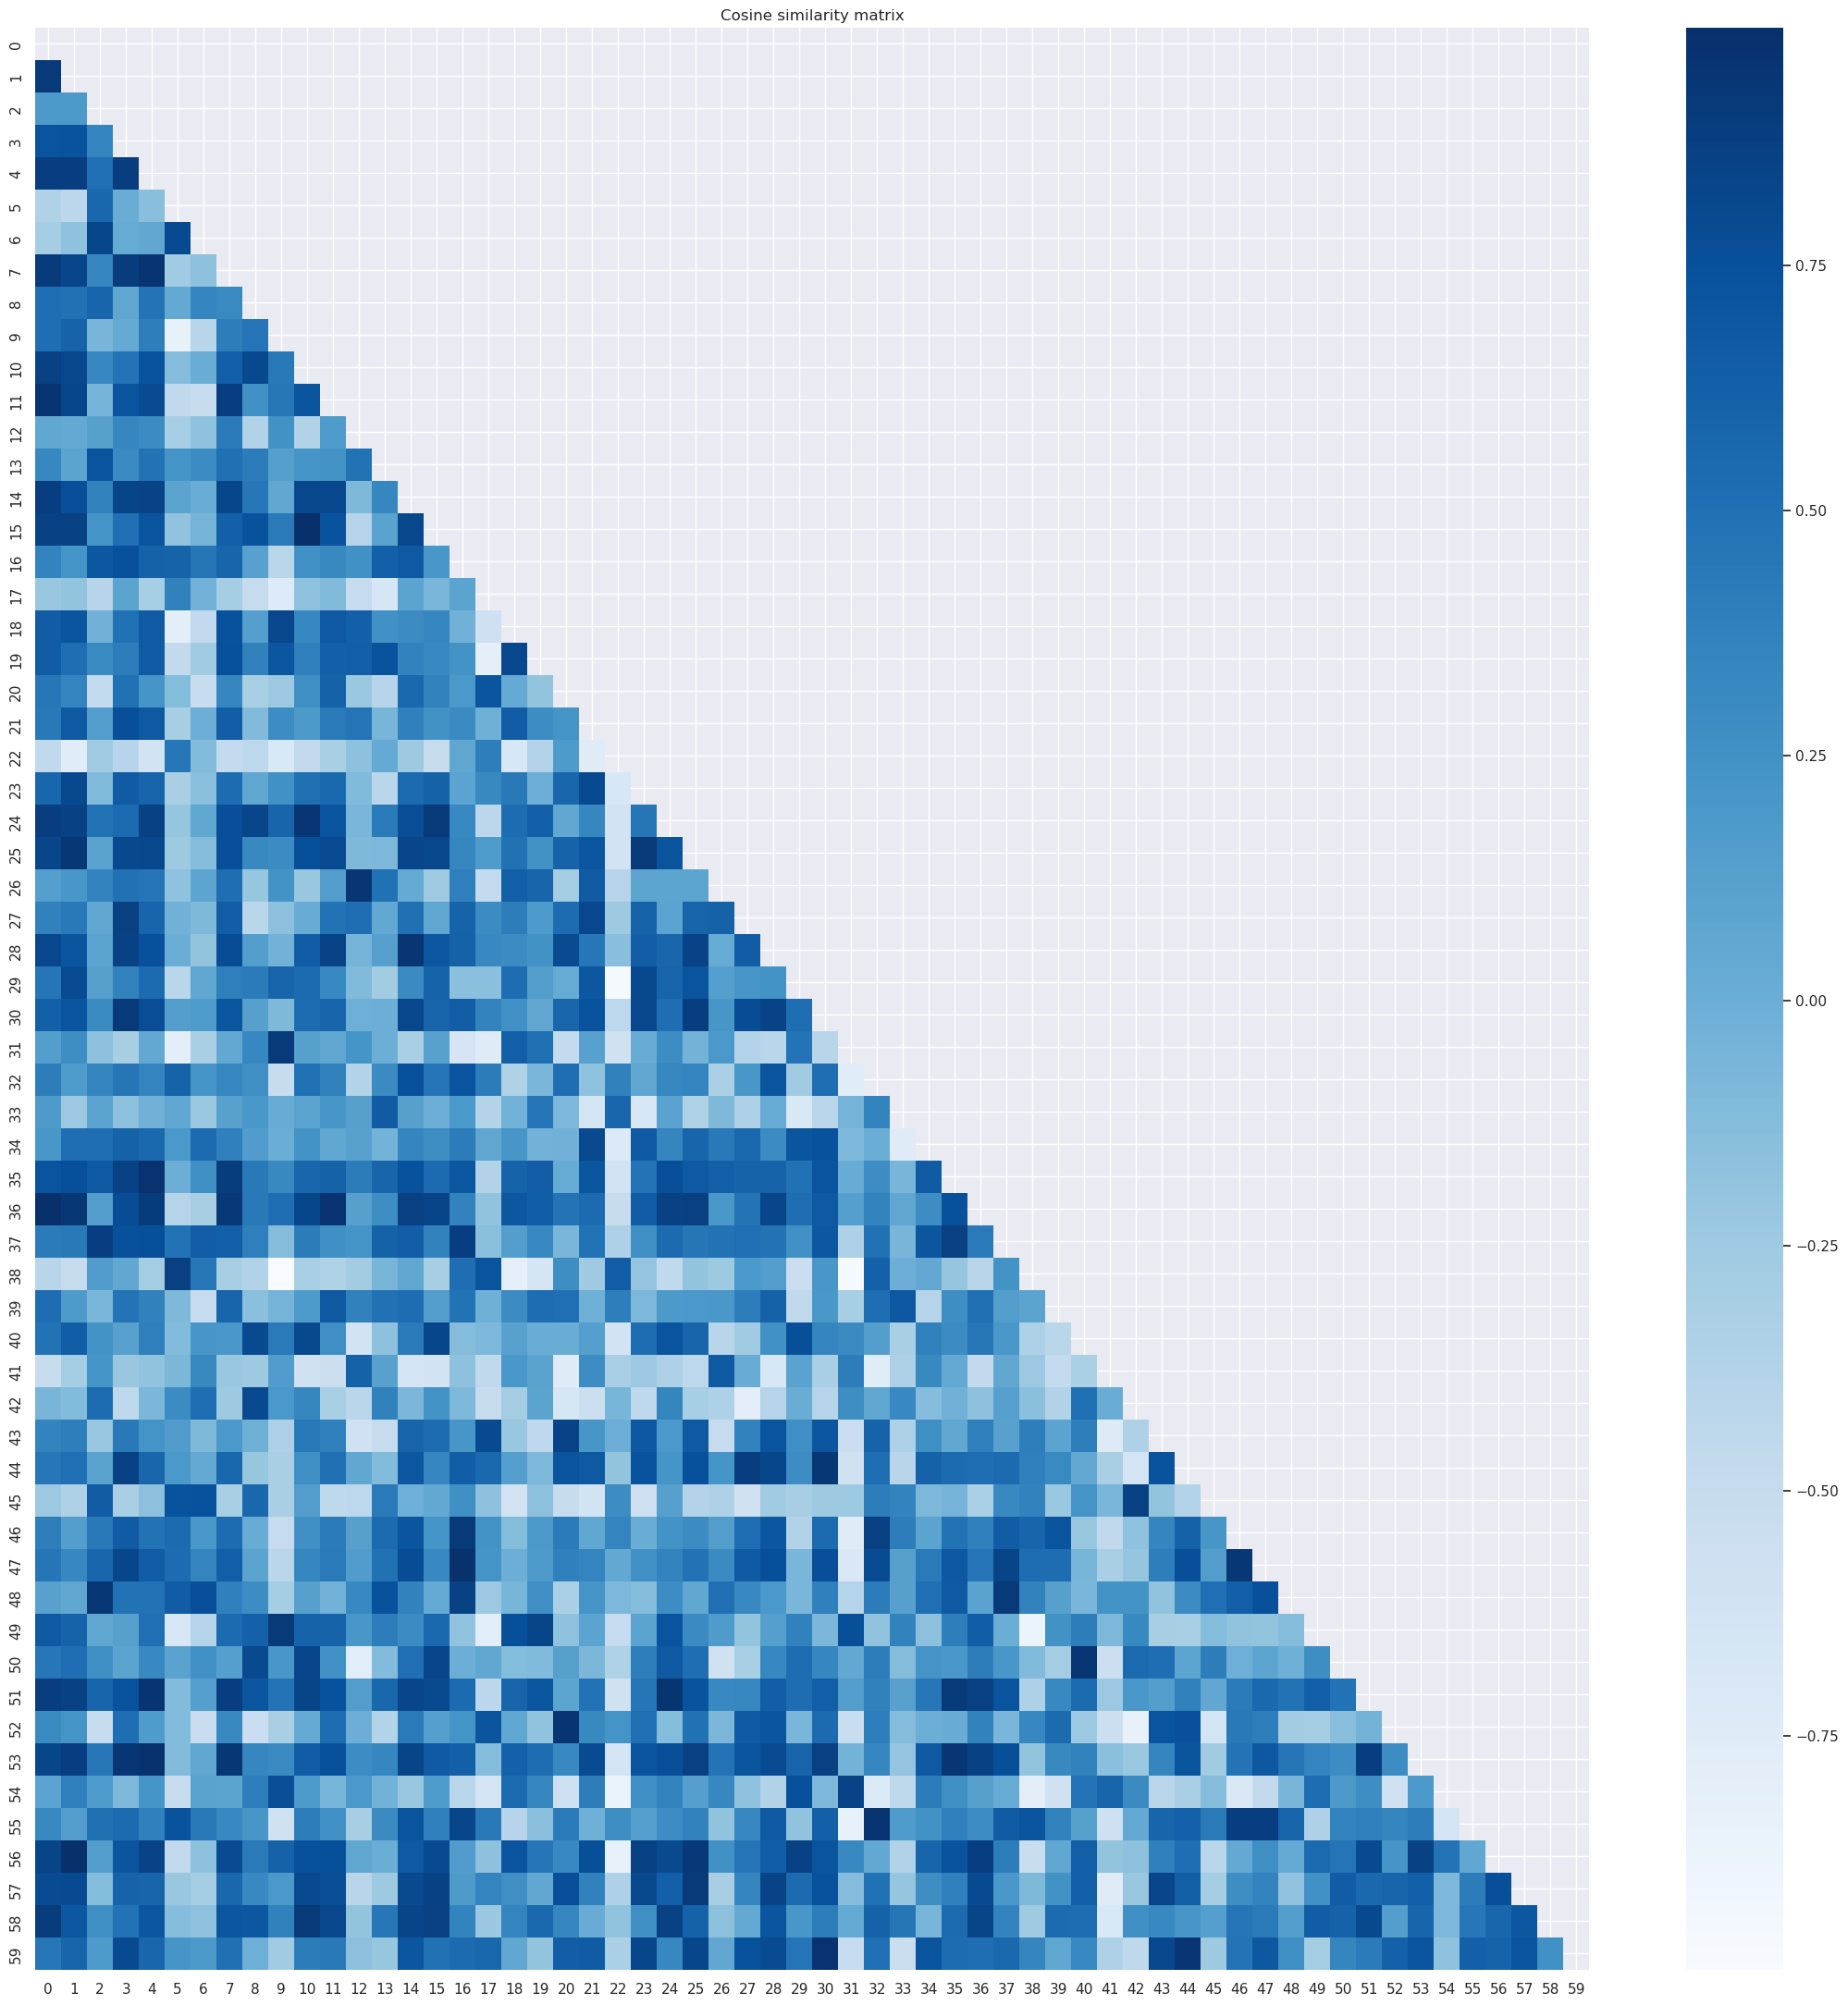

In [78]:
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarity_matrix, annot=False, cmap='Blues', mask=mask, ax=ax)
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.95, top=0.95)
plt.title('Cosine similarity matrix')
plt.show()

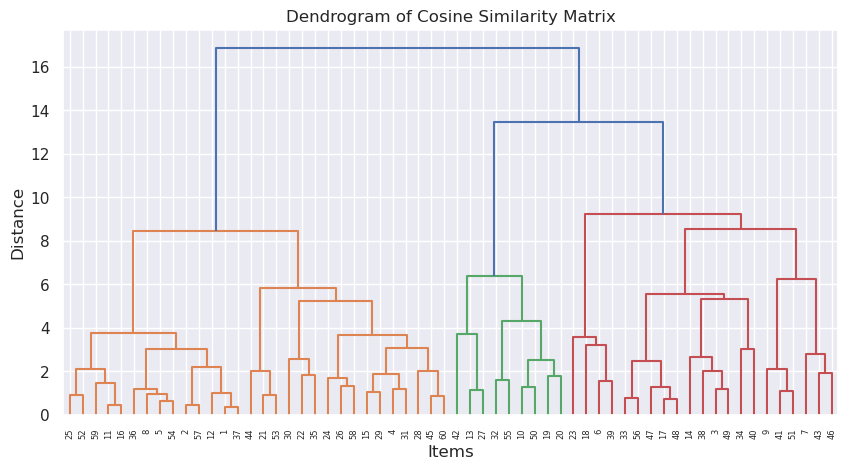

In [79]:
linkage_matrix = linkage(similarity_matrix, method='ward')

fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(linkage_matrix, labels=range(1,61))
plt.title('Dendrogram of Cosine Similarity Matrix')
plt.xlabel('Items')
plt.ylabel('Distance')
plt.show()

In [80]:
cluster_assignments = fcluster(linkage_matrix, t=3, criterion = 'maxclust')

df_sherlock_segments_vader_vec['cluster'] = cluster_assignments
df_sherlock_segments_vader = pd.merge(df_sherlock_segments_vader, df_sherlock_segments_vader_vec[['title', 'cluster']], on='title', how='left')
df_sherlock_pivot = df_sherlock_segments_vader[['title', 'segment_num', 'avg_compound_score', 'cluster']]

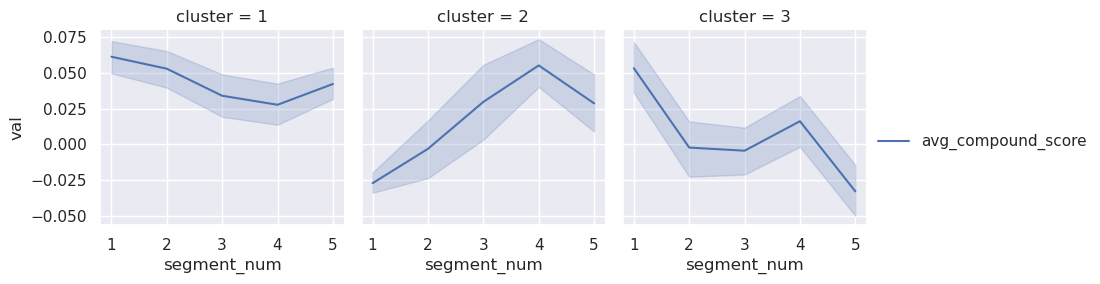

In [81]:
df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title', 'cluster'], var_name='var', value_name= 'val')
fg = sns.FacetGrid(df_sherlock_pivot, col='cluster')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.add_legend()


In [82]:
df_sherlock_pivot_cluster1 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster'] == 1]

df_sherlock_pivot_cluster2 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster'] == 2]

df_sherlock_pivot_cluster3 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster']== 3]

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster1, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster2, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster3, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

<h3> Named Entity Recogniton </h3>

In [83]:
def extract_entities(text):
    pos_tags = nltk.pos_tag(text)
    tree = nltk.ne_chunk(pos_tags)
    return tree

In [84]:
df_sherlock_segments_ner['entities'] = df_sherlock_segments_ner['segments_ner'].apply(extract_entities)

In [85]:
def count_entities(parse_tree, *labels):
    tree = parse_tree
    count = 0
    for subtree in tree.subtrees():
        if subtree.label() in labels:
            count += 1
    return count

In [86]:
df_sherlock_segments_ner['person_entity_count'] = df_sherlock_segments_ner['entities'].apply(lambda parse_tree: count_entities(parse_tree, 'PERSON'))

df_sherlock_segments_ner['location_entity_count'] = df_sherlock_segments_ner['entities'].apply(lambda parse_tree: count_entities(parse_tree, 'LOCATION', 'GPE', 'FACILITY'))

In [87]:
def most_common_entities(row, labels):
    tree = row
    entities = []
    for label in labels:
        entities.extend([subtree.leaves() for subtree in tree.subtrees(lambda t: t.label() == label)])
    flattened_entities = [item for sublist in entities for item in sublist]
    if flattened_entities:
        most_common_entity = max(set(flattened_entities), key=flattened_entities.count)
        return most_common_entity
    else:
        return ''

In [88]:
most_common_persons = df_sherlock_segments_ner['entities'].apply(lambda row: most_common_entities(row, ['PERSON']))

In [89]:
most_common_persons.value_counts().nlargest(10)

entities
(Holmes, NNP)      134
(Mr., NNP)          39
(Watson, NNP)       24
(Sir, NNP)           7
(Miss, NNP)          5
(Brunton, NNP)       4
(Godfrey, NNP)       4
(Von, NNP)           4
(Ferguson, NNP)      3
(Mycroft, NNP)       3
Name: count, dtype: int64

In [90]:
most_common_locations = df_sherlock_segments_ner['entities'].apply(lambda row: most_common_entities(row, ['LOCATION', 'GPE', 'FACILITY']))

In [91]:
most_common_locations.value_counts().nlargest(10)

entities
(London, NNP)     42
(Holmes, NNP)     29
(England, NNP)    10
(Street, NNP)      7
(German, JJ)       5
(Norwood, NNP)     5
(Colonel, NNP)     4
(American, JJ)     4
(West, NNP)        4
                   3
Name: count, dtype: int64

In [92]:
df_sherlock_segments_ner = min_max_scale_column(df_sherlock_segments_ner, 'person_entity_count_norm', 'person_entity_count', 'text_prepro_ner')

df_sherlock_segments_ner = min_max_scale_column(df_sherlock_segments_ner, 'location_entity_count_norm', 'location_entity_count', 'text_prepro_ner')

In [93]:
summary_stats_ner = df_sherlock_segments_ner[['segment_num', 'person_entity_count_norm', 'location_entity_count_norm']].groupby('segment_num').agg(['mean', 'std'])

<Axes: xlabel='segment_num', ylabel="('person_entity_count_norm', 'mean')">

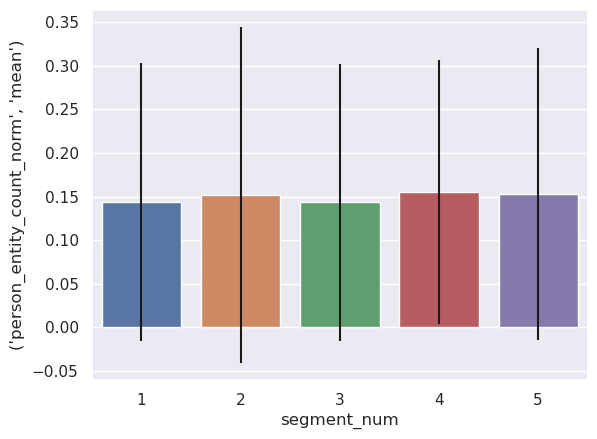

In [94]:
sns.barplot(x=summary_stats_ner.index, y=summary_stats_ner[('person_entity_count_norm', 'mean')], 
            yerr=summary_stats_ner[('person_entity_count_norm', 'std')])

<Axes: xlabel='segment_num', ylabel="('location_entity_count_norm', 'mean')">

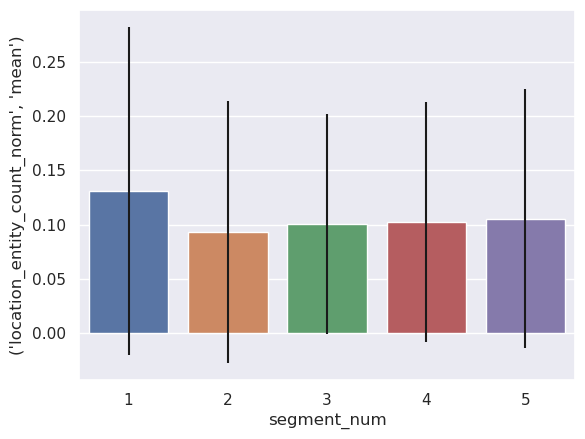

In [95]:
sns.barplot(x=summary_stats_ner.index, y=summary_stats_ner[('location_entity_count_norm', 'mean')], 
            yerr=summary_stats_ner[('location_entity_count_norm', 'std')])

<Axes: xlabel='segment_num', ylabel='value'>

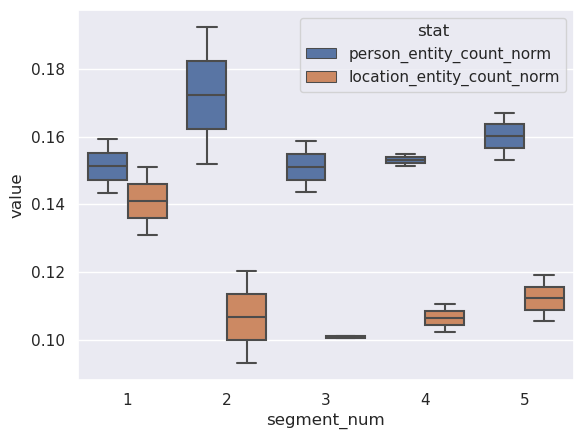

In [96]:
summary_stats_ner = summary_stats_ner.reset_index()

summary_stats_ner = pd.melt(summary_stats_ner, id_vars=['segment_num'], var_name='stat', value_name='value')

summary_stats_ner = summary_stats_ner.drop(index=summary_stats_ner[(summary_stats_ner['stat'] == 'level_0') | summary_stats_ner['stat'] =='index'].index)

sns.boxplot(data = summary_stats_ner, x='segment_num', y='value', hue='stat')

In [97]:
ls_anova = group_df(df_sherlock_segments_ner, 'person_entity_count_norm')

fvalue_person, pvalue_person = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for person entities (fvalue, pvalue): {}, {}'.format(fvalue_person, pvalue_person))

Results for ANOVA test for person entities (fvalue, pvalue): 0.06674727209797983, 0.9917985246195093


In [98]:
ls_anova = group_df(df_sherlock_segments_ner, 'location_entity_count_norm')

fvalue_location, pvalue_location = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for location entities (fvalue, pvalue): {}, {}'.format(fvalue_location, pvalue_location))

Results for ANOVA test for location entities (fvalue, pvalue): 0.8471628687505018, 0.49624403125515426


<Axes: xlabel='plot_element', ylabel='value'>

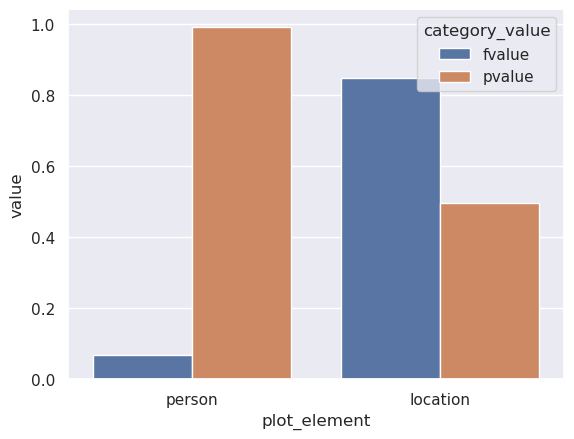

In [99]:
col1 = [fvalue_person, fvalue_location, pvalue_person, pvalue_location]
col2 = ['person', 'location', 'person', 'location']
col3 = ['fvalue', 'fvalue', 'pvalue', 'pvalue']

df_dict = {'value': col1, 'plot_element': col2, 'category_value': col3}

df_anova_ner = pd.DataFrame(df_dict)

sns.barplot(data = df_anova_ner, x='plot_element', y ='value', hue = 'category_value')

In [100]:
df_sherlock_segments_ner_vec = df_sherlock_segments_ner[['title', 'person_entity_count_norm', 'location_entity_count_norm']]

df_sherlock_segments_ner_vec = df_sherlock_segments_ner_vec.groupby('title').agg(lambda x: x.tolist())

df_sherlock_segments_ner_vec['vector'] = df_sherlock_segments_ner_vec.apply(lambda row: [val for sublist in row.values for val in sublist], axis=1)

df_sherlock_segments_ner_vec.reset_index(inplace=True)

df_sherlock_segments_ner_vec = df_sherlock_segments_ner_vec[['title', 'vector']]

matrix_vec = np.array(df_sherlock_segments_ner_vec['vector'].tolist())

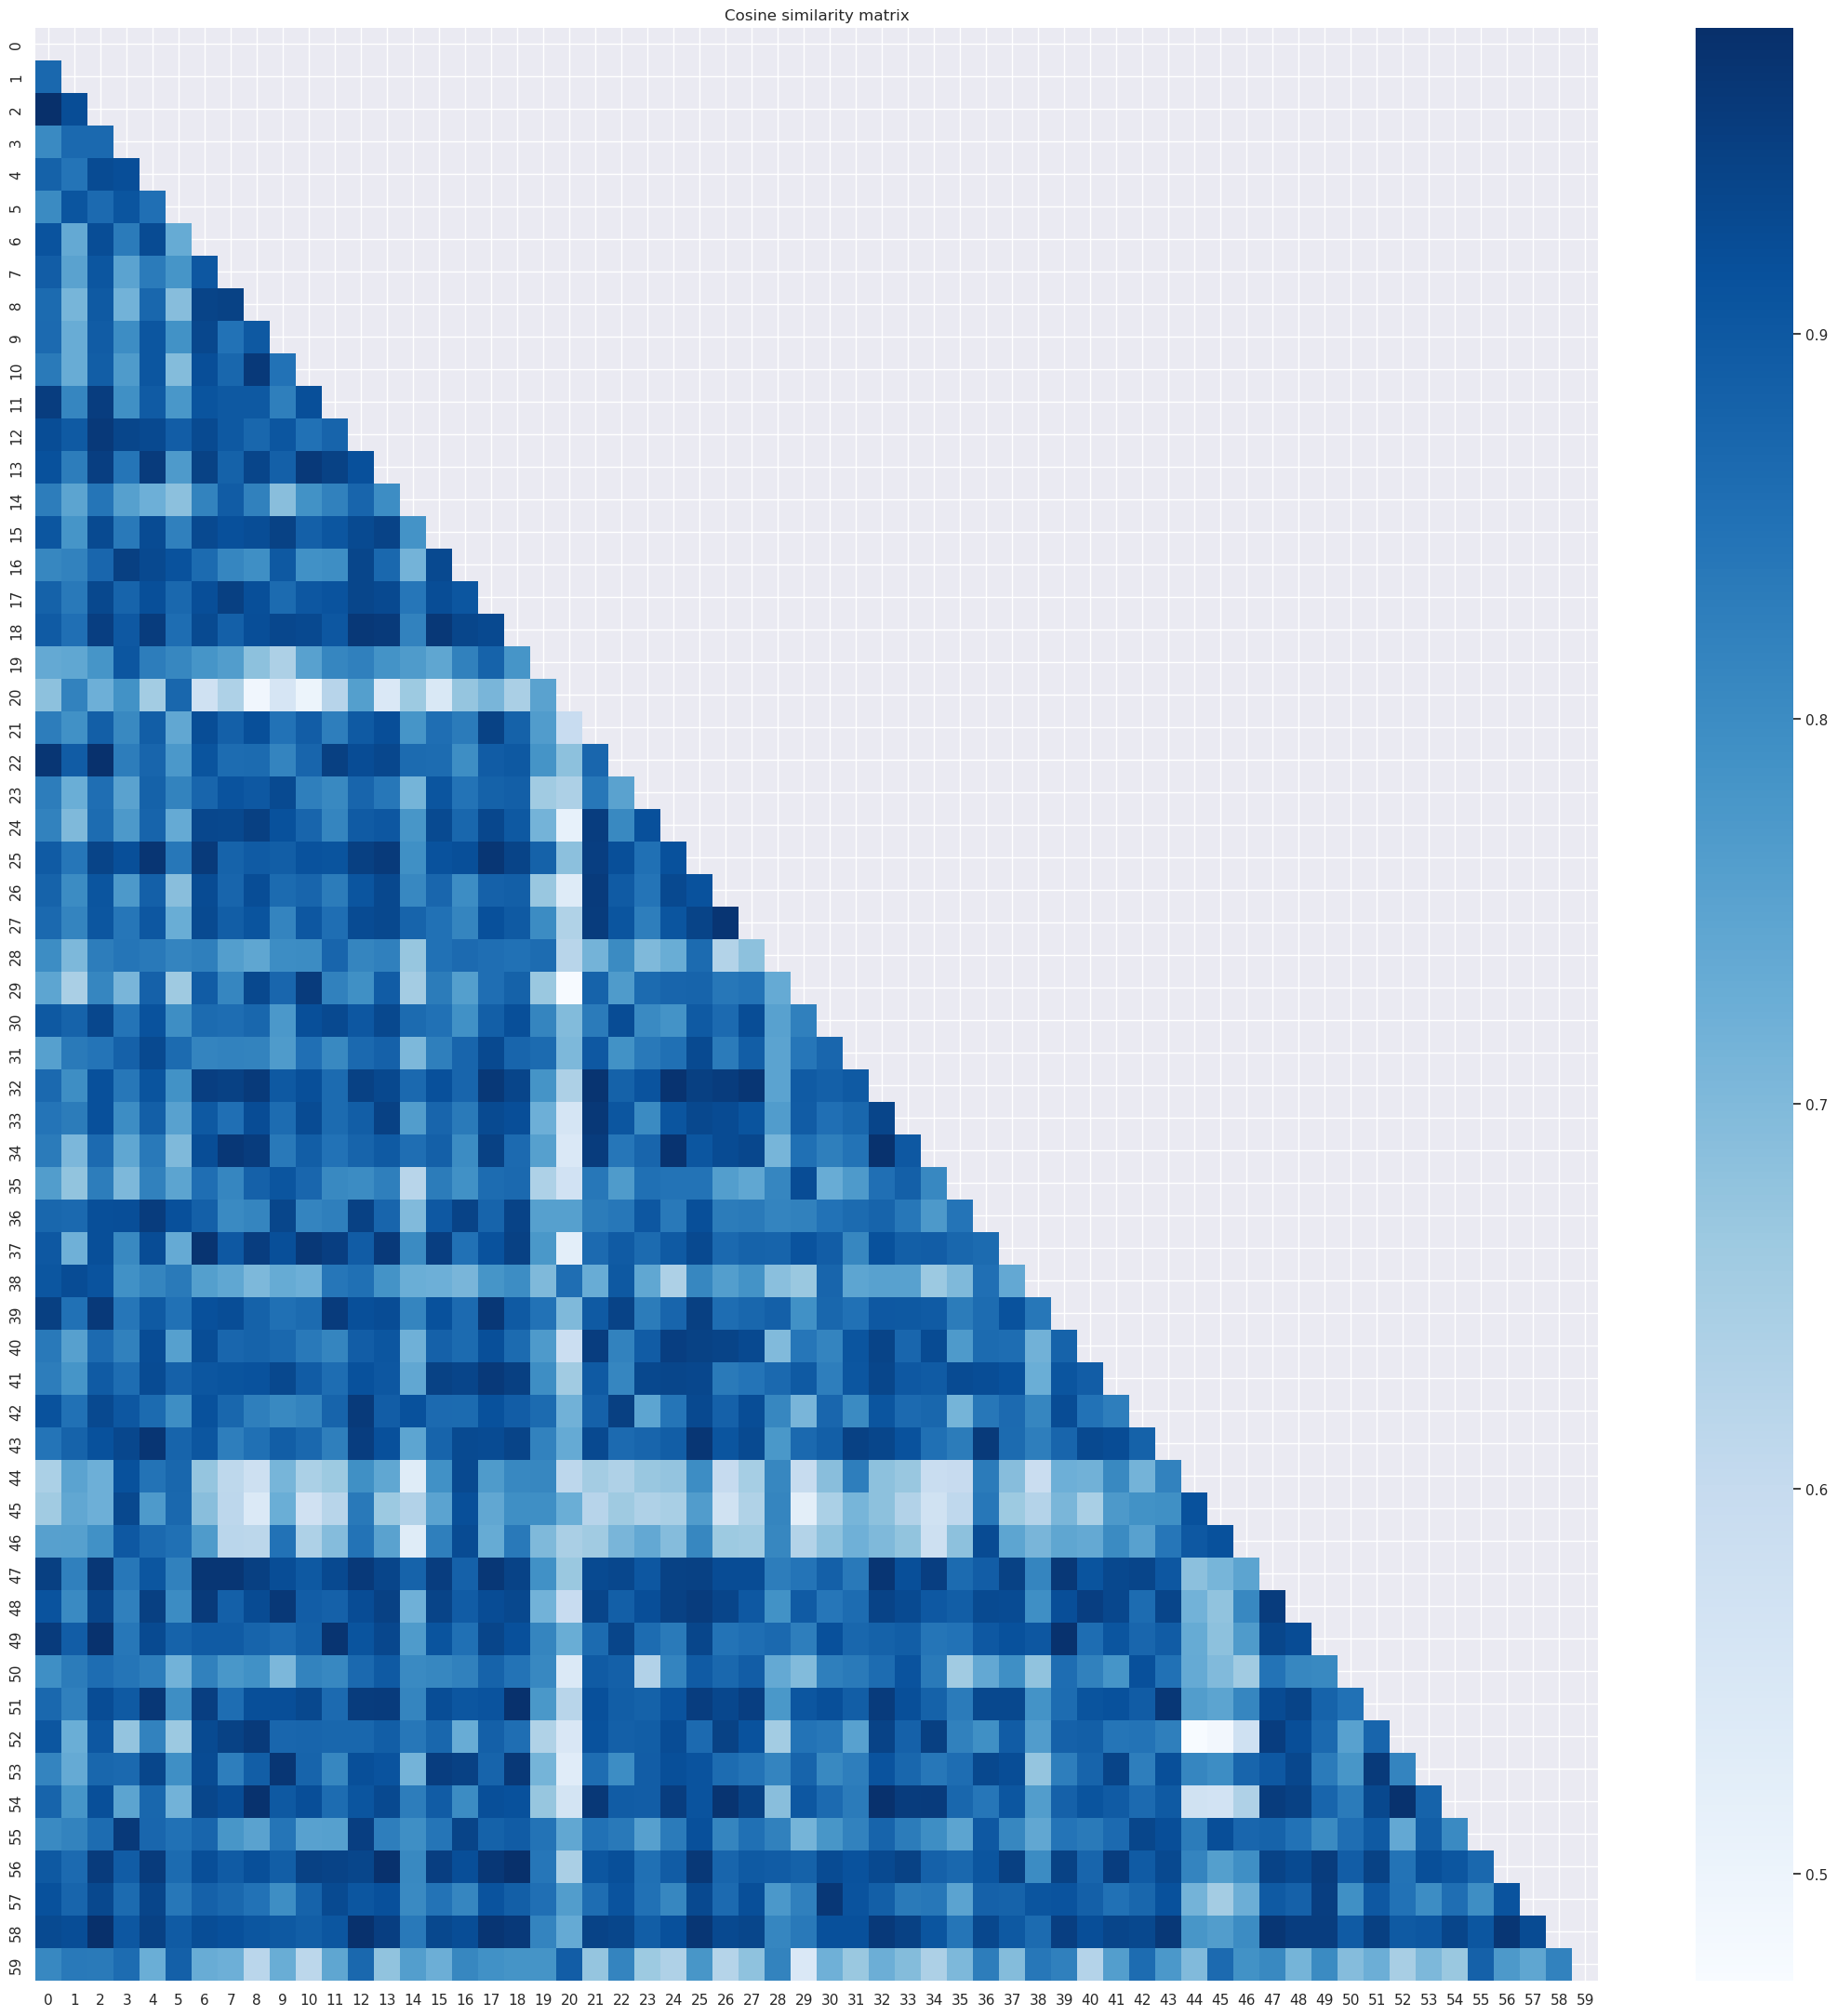

In [101]:
similarity_matrix = cosine_similarity(matrix_vec)
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarity_matrix, annot=False, cmap='Blues', mask=mask, ax=ax)
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.95, top=0.95)
plt.title('Cosine similarity matrix')
plt.show()

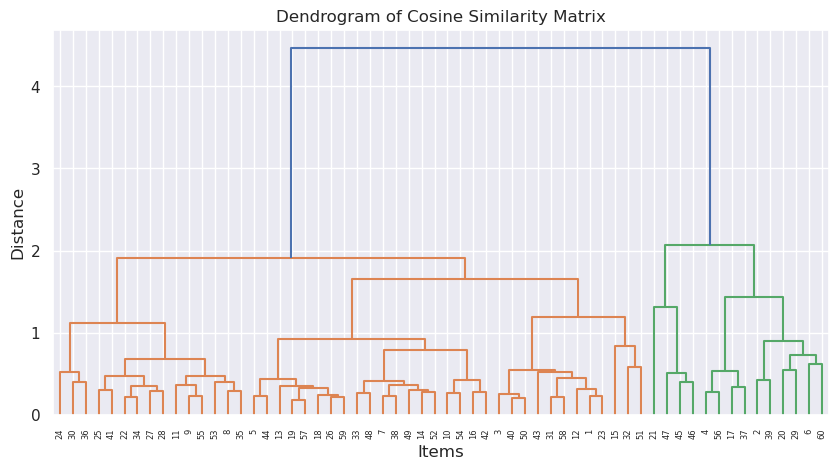

In [102]:
linkage_matrix = linkage(similarity_matrix, method='ward')

fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(linkage_matrix, labels=range(1,61))
plt.title('Dendrogram of Cosine Similarity Matrix')
plt.xlabel('Items')
plt.ylabel('Distance')
plt.show()

In [103]:
cluster_assignments = fcluster(linkage_matrix, t=2, criterion = 'maxclust')

df_sherlock_segments_ner_vec['cluster'] = cluster_assignments

df_sherlock_segments_ner = pd.merge(df_sherlock_segments_ner, df_sherlock_segments_ner_vec[['title', 'cluster']], on='title', how='left')

df_sherlock_pivot = df_sherlock_segments_ner[['title', 'segment_num', 'person_entity_count_norm', 'location_entity_count_norm', 'cluster']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title', 'cluster'], var_name='var', value_name= 'val')

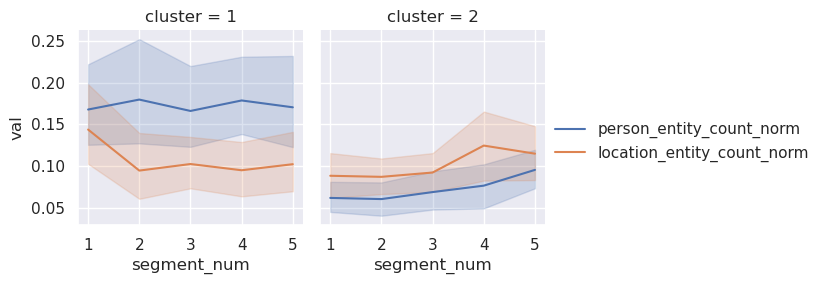

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot, col='cluster')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend()

In [ ]:
df_sherlock_pivot_cluster1 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster'] == 1]

df_sherlock_pivot_cluster2 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster'] == 2]

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster1, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster2, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

<h2> Modeling </h2>

<h3>Clustering</h3>

In [105]:
df_sub1 = df_sherlock_segments_narrative[['title', 'segment_num', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm']]
df_sub2 = df_sherlock_segments_temp[['past_count_norm', 'present_count_norm', 'future_count_norm']]
df_sub3 = df_sherlock_segments_vader[['avg_compound_score']]
df_sub4 = df_sherlock_segments_ner[['person_entity_count_norm', 'location_entity_count_norm']]

df_sherlock_modeling = pd.concat([df_sub1, df_sub2, df_sub3, df_sub4], axis=1)


In [110]:
df_sherlock_modeling_vec = df_sherlock_modeling[['title', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm', 'location_entity_count_norm']]

df_sherlock_modeling_vec = df_sherlock_modeling_vec.groupby('title').agg(lambda x: x.tolist())

df_sherlock_modeling_vec['vector'] = df_sherlock_modeling_vec.apply(lambda row: [val for sublist in row.values for val in sublist], axis=1)
df_sherlock_modeling_vec.reset_index(inplace=True)
df_sherlock_modeling_vec = df_sherlock_modeling_vec[['title', 'vector']]  

In [111]:
vectorizer = CountVectorizer()

features_list = df_sherlock_modeling_vec['vector'].apply(lambda x: ' '.join([str(i) for i in x])).tolist()

sparse_matrix = vectorizer.fit_transform(features_list)

feature_array = sparse_matrix.toarray()

In [130]:
kmeans = KMeans(n_clusters=2, random_state=19)

kmeans.fit(feature_array)

/home/david/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=19)

In [131]:
labels = kmeans.labels_

df_sherlock_modeling_vec['cluster'] = labels

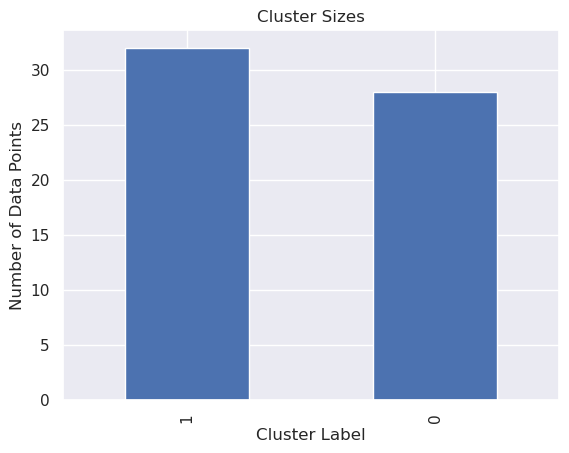

In [132]:
df_sherlock_modeling_vec['cluster'].value_counts().plot(kind='bar')
plt.title('Cluster Sizes')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Data Points')
plt.show()

<h3>PCA</h3>

In [160]:
pca = PCA(n_components=2)

df_sherlock_modeling_pca = df_sherlock_modeling[['title', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm', 'location_entity_count_norm']].groupby('title').agg('mean')

df_sherlock_modeling_pca2 = pca.fit_transform(df_sherlock_modeling_pca[[ 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm', 'location_entity_count_norm']])

df_sherlock_modeling_pca2 = pd.DataFrame(df_sherlock_modeling_pca2, columns=['pca1', 'pca2'])

<Axes: xlabel='pca1', ylabel='pca2'>

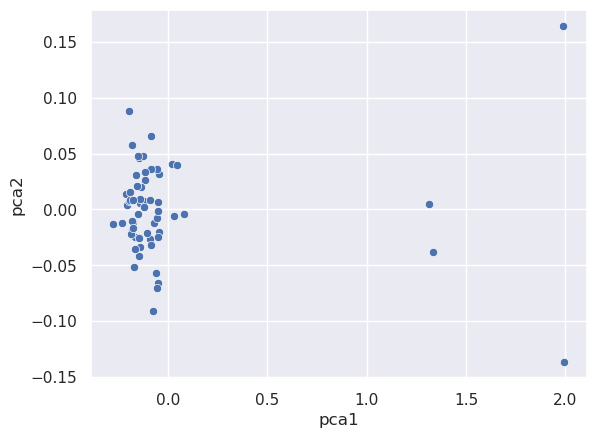

In [157]:
sns.scatterplot(data=df_sherlock_modeling_pca, x="pca1", y="pca2")

In [161]:
pca = PCA(n_components=1)

df_sherlock_modeling_pca1 = pca.fit_transform(df_sherlock_modeling_pca[[ 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm', 'location_entity_count_norm']])

df_sherlock_modeling_pca1 = pd.DataFrame(df_sherlock_modeling_pca1, columns=['pca'])

In [162]:
df_sub = df_sherlock[['title', 'year']]

df_sherlock_modeling_pca1 = pd.concat([df_sherlock_modeling_pca1, df_sub], axis=1)

<Axes: xlabel='year', ylabel='pca'>

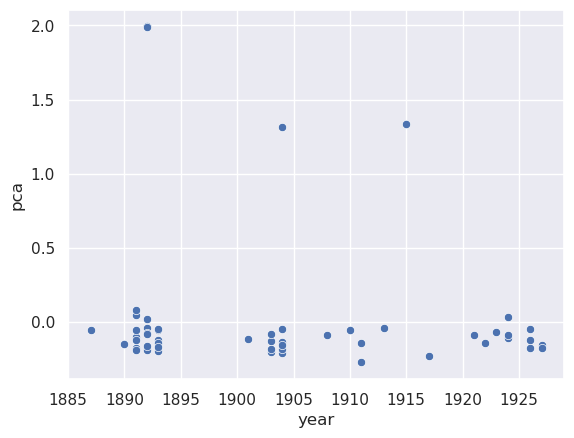

In [163]:
sns.scatterplot(data=df_sherlock_modeling_pca1, x="year", y="pca")

<h3>Logistic Regression</h3>

In [166]:
X_train, X_test, y_train, y_test = train_test_split(df_sherlock_modeling[['staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm', 'location_entity_count_norm']], df_sherlock_modeling['segment_num'], test_size=0.2, random_state=19)

logreg = LogisticRegression(multi_class='ovr', solver='liblinear')

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = logreg.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.18333333333333332


In [ ]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, thresholds= metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="classifier, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend(loc=4)
plt.title("ROC-curve")
plt.show()

<h2> Conclusion </h2>

<h2>TODOs/Ideas</h2>

- try to segment data according to years